# Altermagnetic superconductors

In [24]:
import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from amsc import (
    impurity_system,
    bulk_amsc_system,
    generate_intial_Delta,
    setup_gaussian_impurities,
)
from plot_tools import add_tl_label, complex_plot
from scipy.interpolate import RegularGridInterpolator
from tqdm.notebook import tqdm
from pauli import *
from qm_tools import thermal_broadening, sparse_diag

In [25]:
# eigsh = sla.eigsh
eigsh = sparse_diag  # MUMPS

In [26]:
plt.style.use("../plot_style.mplstyle")

# System Setup

In [27]:
periodic_bc = True

Nx = 61
Ny = 61

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 5.0
t_so = 0.0 * t
t_am = 0.25 * t

mu = 2.5
hz0 = 1e-6
hx0 = 0
hy0 = 0

# Temperature
T = 0.01

# Select the number of eigenvalues to calculate (it will set the energy cutoff)
N = 1024

# Self consistency loops
Nloops = 1

# Sparse or dense diagonalization
sparse = True

## Initial value for Delta (will be used to determine g)
Delta_init = 1

In [28]:
k_F = np.arccos(1 - mu / (4 * t))
lambda_F = (2 * np.pi) / k_F
eta = t_am / t
omega_mg = Delta_init - eta * mu

print(f"lambda_F is {lambda_F:3.3f}")
print(f"The minigap is located at {omega_mg:3.3f}")

lambda_F is 12.433
The minigap is located at 0.375


In [29]:
vortex_positions = []
windings = []
l_core = 0  # l_core is the decay length of the order parameter (in a vortex that is the coherence length)

Delta, theta = generate_intial_Delta(
    x=x,
    y=y,
    Delta_init=Delta_init,
    vortex_positions=vortex_positions,
    windings=windings,
    l_core=l_core,
)

In [30]:
# Impurituy positions
impurity_positions = [(0, 0)]  # , (-10, 0)]
impurity_sizes = [2.2]  # Sizes
impurity_eccentricities = [0.0]  # Eccentricity
impurity_orientation = [0.0]  # Orientation


V_imp = [-25]  # Impurity potential (negative = attractive)
hx_imp = [0.0]  # Impurity field
hy_imp = [0.0]  # Impurity field
hz_imp = [0.0]  # Impurity field

V, hx, hy, hz = setup_gaussian_impurities(
    x=x,
    y=y,
    mu=mu,
    hx0=hx0,
    hy0=hy0,
    hz0=hz0,
    impurity_sizes=impurity_sizes,
    impurity_positions=impurity_positions,
    impurity_eccentricities=impurity_eccentricities,
    impurity_orientations=impurity_orientation,
    V_imp=V_imp,
    hx_imp=hx_imp,
    hy_imp=hy_imp,
    hz_imp=hz_imp,
)

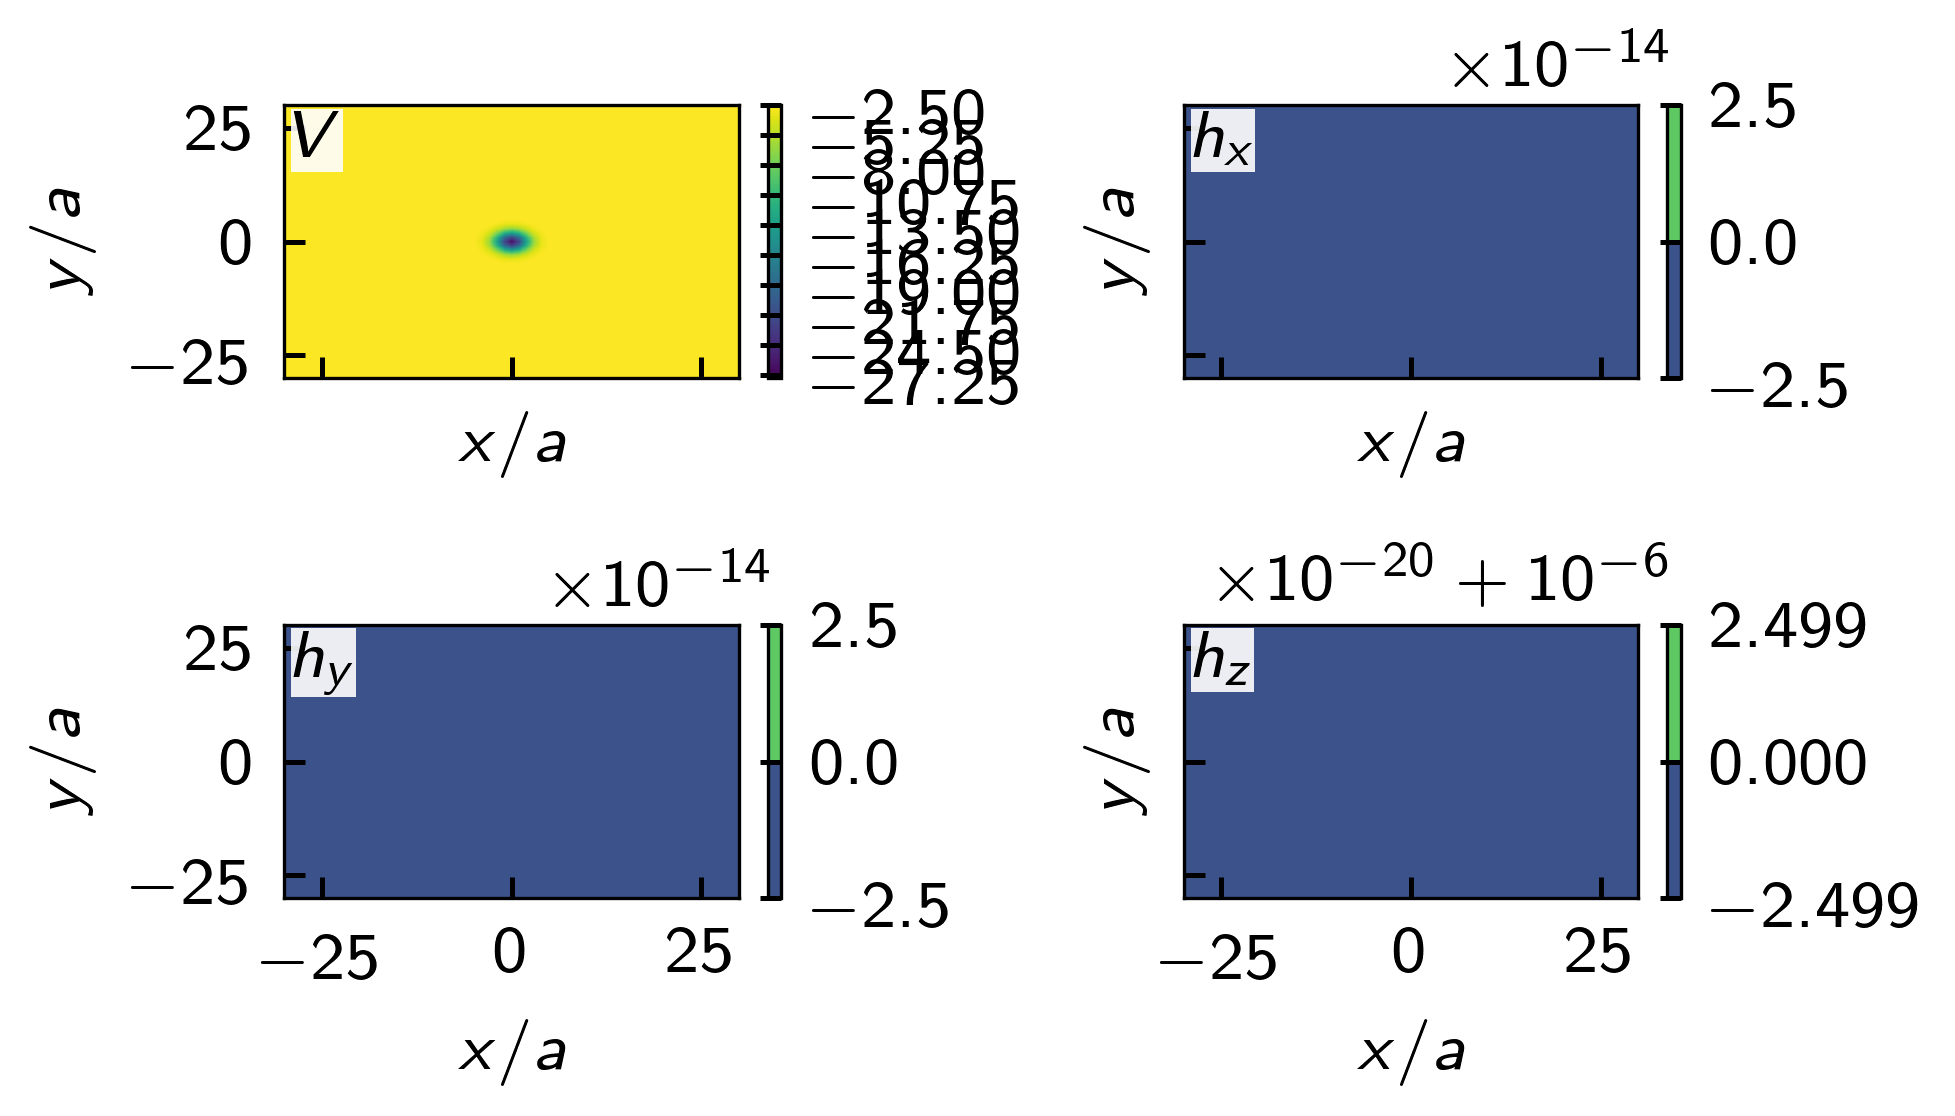

In [31]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)

# Plot for V(x, y)
im1 = axs[0, 0].contourf(x, y, V(x, y), levels=100)
add_tl_label(
    axs[0, 0],
    r"$V$",
)
axs[0, 0].set_xlabel(r"$x/a$")
axs[0, 0].set_ylabel(r"$y/a$")

# Plot for hx(x, y)
im2 = axs[0, 1].contourf(x, y, hx(x, y))
add_tl_label(axs[0, 1], r"$h_x$")
axs[0, 1].set_xlabel(r"$x/a$")
axs[0, 1].set_ylabel(r"$y/a$")

# Plot for hy(x, y)
im3 = axs[1, 0].contourf(x, y, hy(x, y))
add_tl_label(axs[1, 0], r"$h_y$")
axs[1, 0].set_xlabel(r"$x/a$")
axs[1, 0].set_ylabel(r"$y/a$")

# Plot for hz(x, y)
im4 = axs[1, 1].contourf(x, y, hz(x, y))
add_tl_label(axs[1, 1], r"$h_z$")
axs[1, 1].set_xlabel(r"$x/a$")
axs[1, 1].set_ylabel(r"$y/a$")

fig.colorbar(im1)
fig.colorbar(im2)
fig.colorbar(im3)
fig.colorbar(im4)

fig.tight_layout()

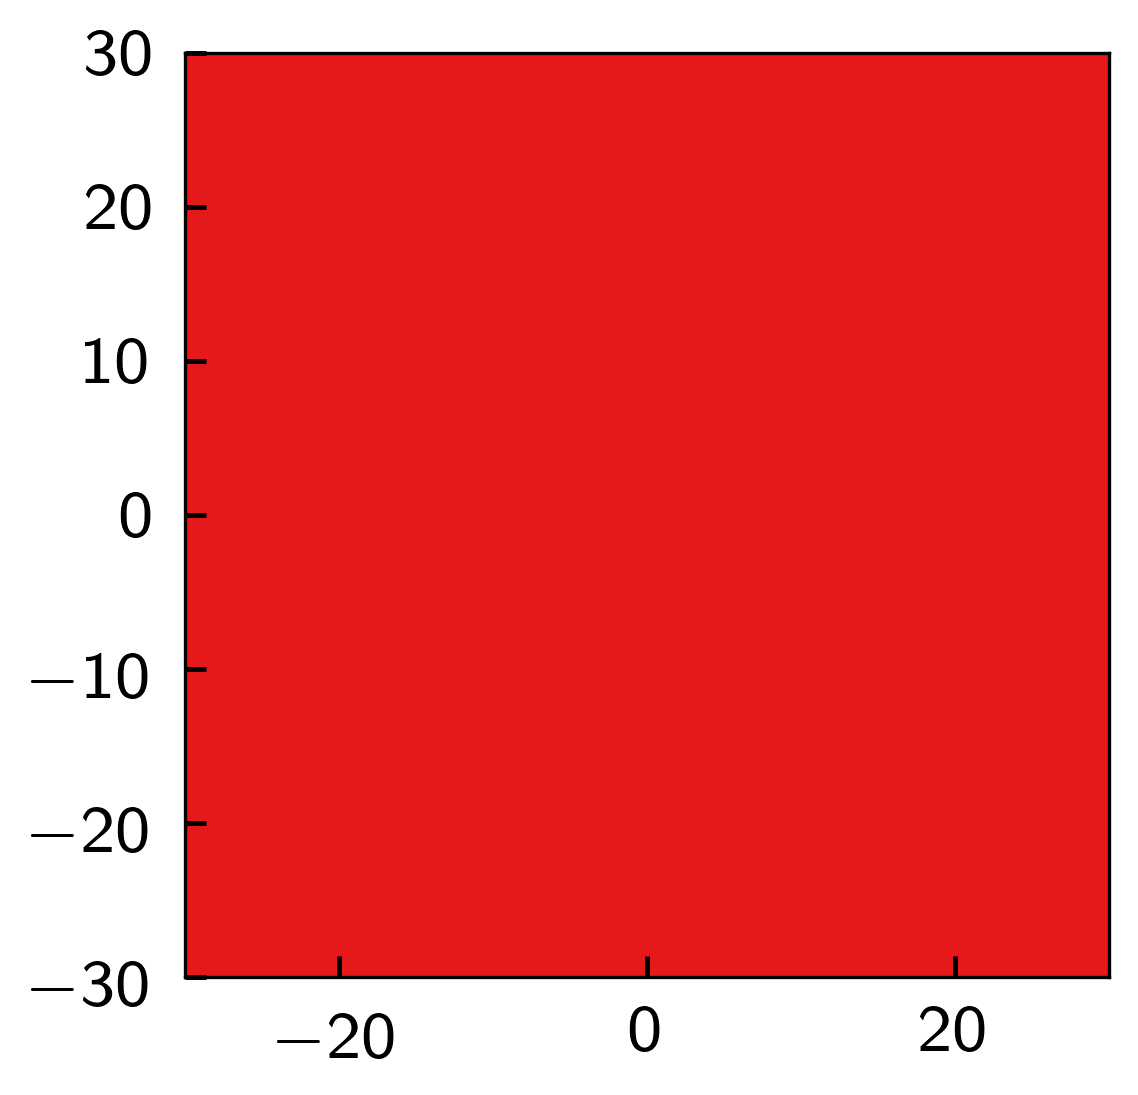

In [32]:
# Show the order parameter
fig, ax, im = complex_plot(x, y, Delta(x, y) * np.exp(1j * theta(x, y)))

In [33]:
def create_system(Delta, theta):
    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    return syst.finalized()

In [34]:
fsyst = create_system(Delta, theta)

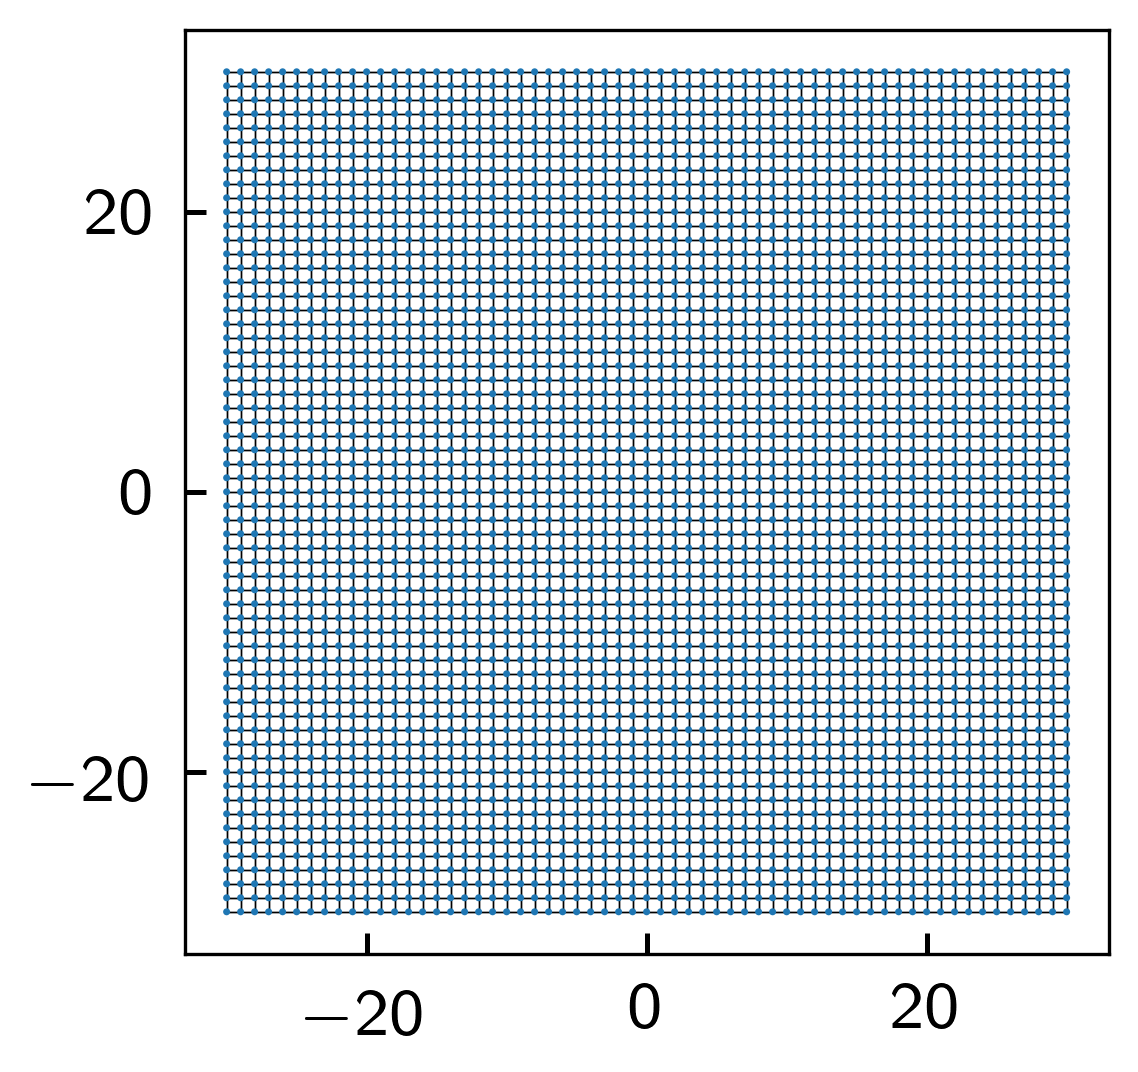

In [35]:
kwant.plot(fsyst);

In [36]:
# Quasiparticle density
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)

# Electric charge
tzs0_op = kwant.operator.Density(fsyst, onsite=tzs0, sum=False)

# Spin
tzsx_op = kwant.operator.Density(fsyst, onsite=tzsx, sum=False)
tzsy_op = kwant.operator.Density(fsyst, onsite=tzsy, sum=False)
tzsz_op = kwant.operator.Density(fsyst, onsite=tzsz, sum=False)

# Singlet correlations
txs0_op = kwant.operator.Density(fsyst, onsite=txs0, sum=False)
tys0_op = kwant.operator.Density(fsyst, onsite=tys0, sum=False)

# Triplet correlations
txsx_op = kwant.operator.Density(fsyst, onsite=txsx, sum=False)
tysx_op = kwant.operator.Density(fsyst, onsite=tysx, sum=False)
txsy_op = kwant.operator.Density(fsyst, onsite=txsy, sum=False)
tysy_op = kwant.operator.Density(fsyst, onsite=tysy, sum=False)
txsz_op = kwant.operator.Density(fsyst, onsite=txsz, sum=False)
tysz_op = kwant.operator.Density(fsyst, onsite=tysz, sum=False)

# Currents
j_t0s0_op = kwant.operator.Current(fsyst, onsite=t0s0)
j_tzs0_op = kwant.operator.Current(fsyst, onsite=tzs0)
j_tzsz_op = kwant.operator.Current(fsyst, onsite=tzsz)

# Exact diagonalization

## Self-consistency

We first diagonalize the system once and by comparing the triplet correlations simulated with the original delta, we deterimne
the coupling constant $g$. Then we exectue the same diagonalization and update of the order parameter for$N_\mathrm{loops}$ times keeping $g$ fixed.

In [37]:
%%time

if sparse == True:
    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

else:
    ws, vs = la.eigh(fsyst.hamiltonian_submatrix())
    N = 4 * Nx * Ny

sort_idxs = np.argsort(ws)
vs = vs[:, sort_idxs]
ws = ws[sort_idxs]

omega_cutoff = ws[-1]

CPU times: user 52min 30s, sys: 39min 48s, total: 1h 32min 18s
Wall time: 10min 57s


In [38]:
print(f"The energy cutoff is {omega_cutoff:5.3f}")

if omega_cutoff < Delta_init + eta * mu:
    print("Warning: cutoff too low!")

The energy cutoff is 2.158


In [39]:
txs0_ev = np.zeros((N, Nx * Ny))
tys0_ev = np.zeros((N, Nx * Ny))
for i in range(N):
    txs0_ev[i] = txs0_op(vs[:, i])
    tys0_ev[i] = tys0_op(vs[:, i])

Fx = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T)))
Fy = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T)))

g = Delta_init / np.mean(np.sqrt(Fx**2 + Fy**2))

Delta_n = g * np.sqrt(Fx**2 + Fy**2)
theta_n = -np.arctan2(Fy, Fx)

print(f"The coupling constant is {g:5.3f}")

The coupling constant is 5.250


In [40]:
diff = np.mean((Delta_n.reshape(Ny, Nx) - Delta(x, y)) ** 2)
diff

0.0032541764474094724

In [41]:
Delta_interp = RegularGridInterpolator((y_ax, x_ax), Delta_n.reshape(Ny, Nx))
theta_interp = RegularGridInterpolator((y_ax, x_ax), theta_n.reshape(Ny, Nx))

Delta = lambda x, y: Delta_interp((y, x))
theta = lambda x, y: theta_interp((y, x))

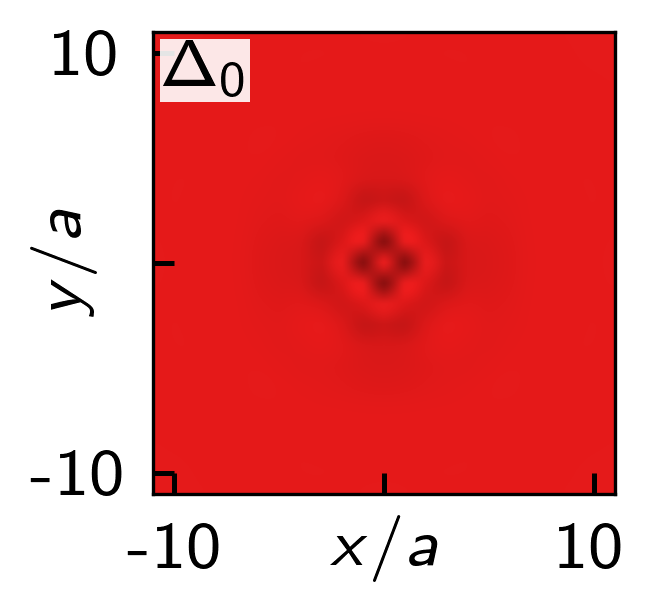

In [43]:
fig, ax = plt.subplots(figsize=(1, 1))

complex_plot(
    x,
    y,
    Delta(x, y),
    ax=ax,
    interpolation="spline16",
)

add_tl_label(ax, r"$\Delta_0$")


ax.set_xticks([-10, 0, 10], labels=["-10", "", "10"])
ax.set_yticks([-10, 0, 10], labels=["-10", "", "10"])

ax.set_xlim(-11, 11)
ax.set_ylim(-11, 11)

ax.set_xlabel(r"$x/a$", labelpad=-8)
ax.set_ylabel(r"$y/a$", labelpad=-8)

ax.set_rasterized(True)

In [19]:
mixing_rate = 0.75

for iter_number in range(Nloops):
    # Create a new system with the new order parameter
    fsyst = create_system(
        Delta=Delta,
        theta=theta,
    )

    # Diagonalize the sytem
    if sparse == True:
        ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)
    else:
        ws, vs = la.eigh(fsyst.hamiltonian_submatrix())

    sort_idxs = np.argsort(ws)
    vs = vs[:, sort_idxs]
    ws = ws[sort_idxs]

    # Calculate correlation functions
    txs0_ev = np.zeros((N, Nx * Ny))
    tys0_ev = np.zeros((N, Nx * Ny))
    for i in range(N):
        txs0_ev[i] = txs0_op(vs[:, i])
        tys0_ev[i] = tys0_op(vs[:, i])

    Fx = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T)))
    Fy = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T)))

    # Calculate the order parameter
    Delta_n_new = g * np.sqrt(Fx**2 + Fy**2)
    theta_n_new = -np.arctan2(Fy, Fx)

    Delta_n = (1 - mixing_rate) * Delta_n + mixing_rate * Delta_n_new
    theta_n = (1 - mixing_rate) * theta_n + mixing_rate * theta_n_new

    diff = np.mean((Delta_n.reshape(Nx, Ny) - Delta(x, y)) ** 2)
    print(f"Iteration {iter_number:2d}, the average error is: {diff:5f}")

    # Create the new interpolation functions
    Delta_interp = RegularGridInterpolator((y_ax, x_ax), Delta_n.reshape(Ny, Nx))
    theta_interp = RegularGridInterpolator((y_ax, x_ax), theta_n.reshape(Ny, Nx))

    # Update the order parameter
    Delta = lambda x, y: Delta_interp((y, x))
    theta = lambda x, y: theta_interp((y, x))

Iteration  0, the average error is: 0.000437
Iteration  1, the average error is: 0.000013
Iteration  2, the average error is: 0.000002
Iteration  3, the average error is: 0.000010


## Analysis of anomalous correlations

In [43]:
# Calculate correlation functions
txs0_ev = np.zeros((N, Nx * Ny))
tys0_ev = np.zeros((N, Nx * Ny))
txsx_ev = np.zeros((N, Nx * Ny))
tysx_ev = np.zeros((N, Nx * Ny))
txsy_ev = np.zeros((N, Nx * Ny))
tysy_ev = np.zeros((N, Nx * Ny))
txsz_ev = np.zeros((N, Nx * Ny))
tysz_ev = np.zeros((N, Nx * Ny))

for i in range(N):
    txs0_ev[i] = txs0_op(vs[:, i])
    tys0_ev[i] = tys0_op(vs[:, i])

    txsx_ev[i] = txsx_op(vs[:, i])
    tysx_ev[i] = tysx_op(vs[:, i])

    txsy_ev[i] = txsy_op(vs[:, i])
    tysy_ev[i] = tysy_op(vs[:, i])

    txsz_ev[i] = txsz_op(vs[:, i])
    tysz_ev[i] = tysz_op(vs[:, i])

F0_re = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
F0_im = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fx_re = np.einsum("ni, n -> i", txsx_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fx_im = np.einsum("ni, n -> i", tysx_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fy_re = np.einsum("ni, n -> i", txsy_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fy_im = np.einsum("ni, n -> i", tysy_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fz_re = np.einsum("ni, n -> i", txsz_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fz_im = np.einsum("ni, n -> i", tysz_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T

F0_abs = np.sqrt(F0_re**2 + F0_im**2)
F0_theta = np.arctan2(F0_im, F0_re)
Fx_abs = np.sqrt(Fx_re**2 + Fx_im**2)
Fx_theta = np.arctan2(Fx_im, Fx_re)
Fy_abs = np.sqrt(Fy_re**2 + Fy_im**2)
Fy_theta = np.arctan2(Fy_im, Fy_re)
Fz_abs = np.sqrt(Fy_re**2 + Fy_im**2)
Fz_theta = np.arctan2(Fy_im, Fy_re)

In [44]:
Fx_abs.max()

7.477622635507103e-11

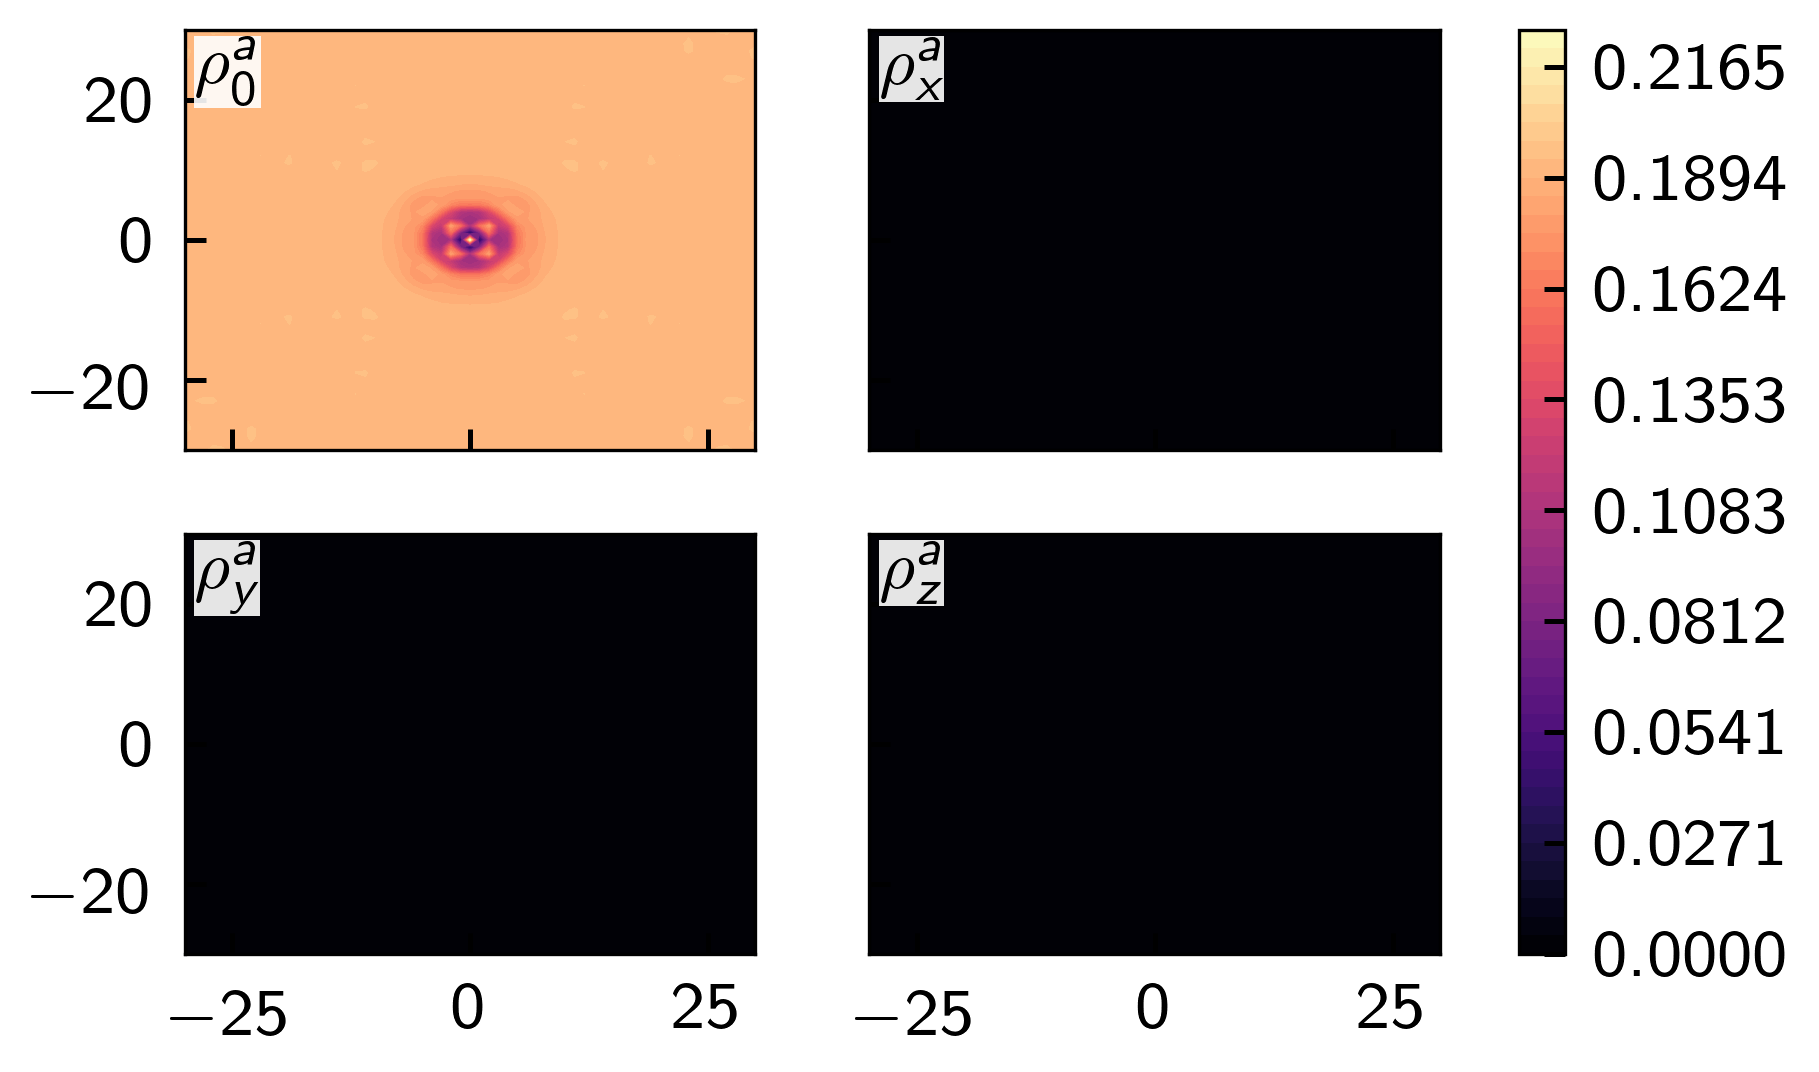

In [45]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
im00 = axs[0, 0].contourf(
    x, y, F0_abs, cmap="magma", levels=np.linspace(0, 1, 51) * F0_abs.max()
)
axs[0, 1].contourf(
    x, y, Fx_abs, cmap="magma", levels=np.linspace(0, 1, 51) * F0_abs.max()
)
axs[1, 0].contourf(
    x, y, Fy_abs, cmap="magma", levels=np.linspace(0, 1, 51) * F0_abs.max()
)
axs[1, 1].contourf(
    x, y, Fz_abs, cmap="magma", levels=np.linspace(0, 1, 51) * F0_abs.max()
)

cbar00 = fig.colorbar(im00, ax=axs, location="right")

add_tl_label(axs[0, 0], r"$\rho^a_0$")
add_tl_label(axs[0, 1], r"$\rho^a_x$")
add_tl_label(axs[1, 0], r"$\rho^a_y$")
add_tl_label(axs[1, 1], r"$\rho^a_z$")

Text(0, 0.5, '$y/a$')

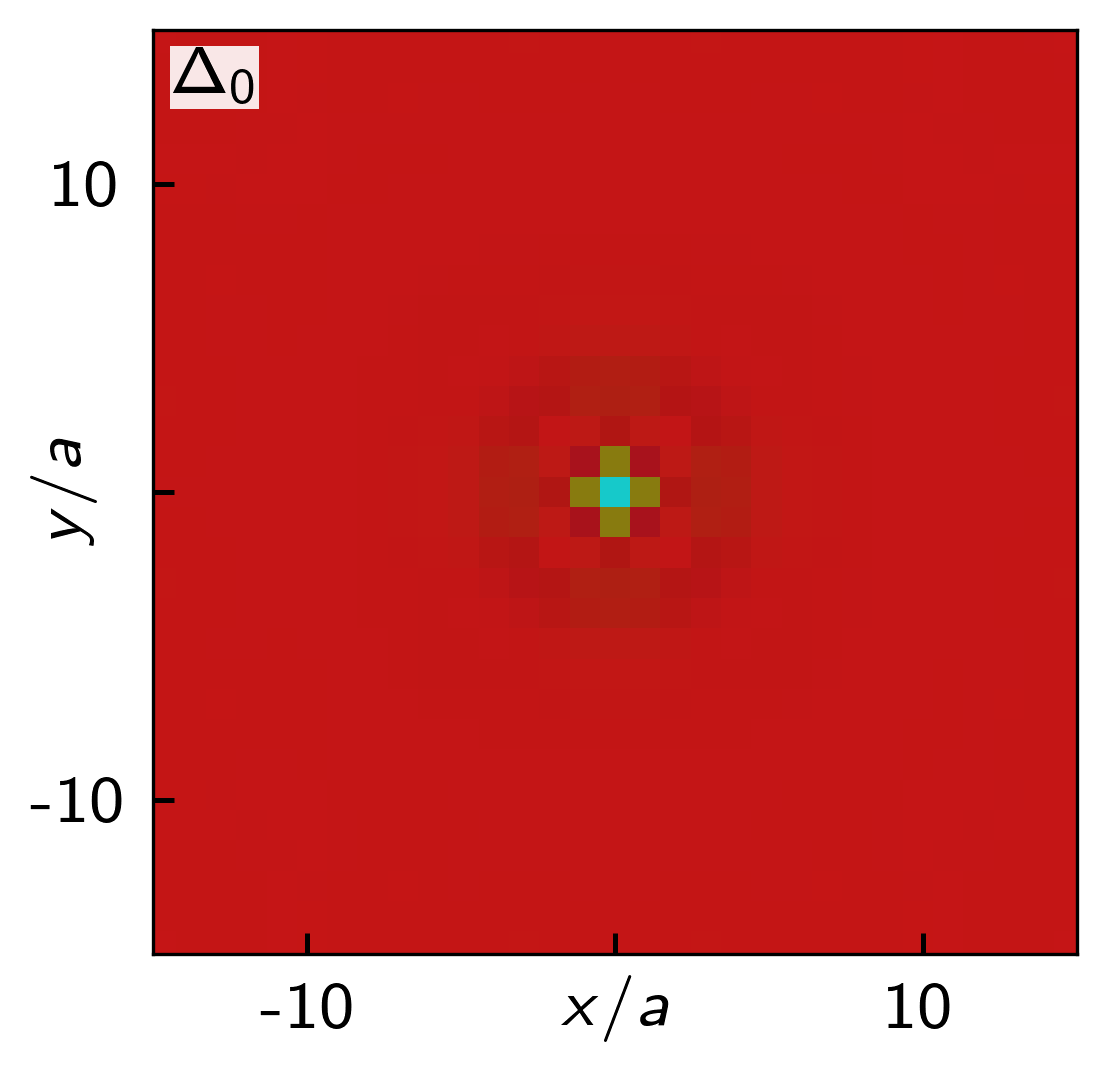

In [92]:
fig, ax = plt.subplots()
complex_plot(
    x,
    y,
    2 * F0_abs * np.exp(1j * (F0_theta - F0_theta.mean())),
    ax=ax,
    interpolation="none",#"spline16",
)

add_tl_label(ax, r"$\Delta_0$")


ax.set_xticks([-10, 0, 10], labels=["-10", "", "10"])
ax.set_yticks([-10, 0, 10], labels=["-10", "", "10"])

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)

ax.set_xlabel(r"$x/a$", labelpad=-8)
ax.set_ylabel(r"$y/a$", labelpad=-8)

In [81]:
Delta_init = Delta_n.mean()

## Single states analysis

In [82]:
# Select the subgap state to analyze
idx = len(ws) // 2

In [83]:
ws[idx : idx + 8]

array([0.11697633, 0.11697833, 0.39001205, 0.39001405, 0.39144191,
       0.39144391, 0.4009261 , 0.4009281 ])

In [84]:
omega_mg - ws[idx]  # +0.016

0.25802367251078845

In [85]:
(-0.016) * eta

-0.004

In [86]:
omega_mg - ws[idx]

0.25802367251078845

Text(0, 0.5, 'Energy')

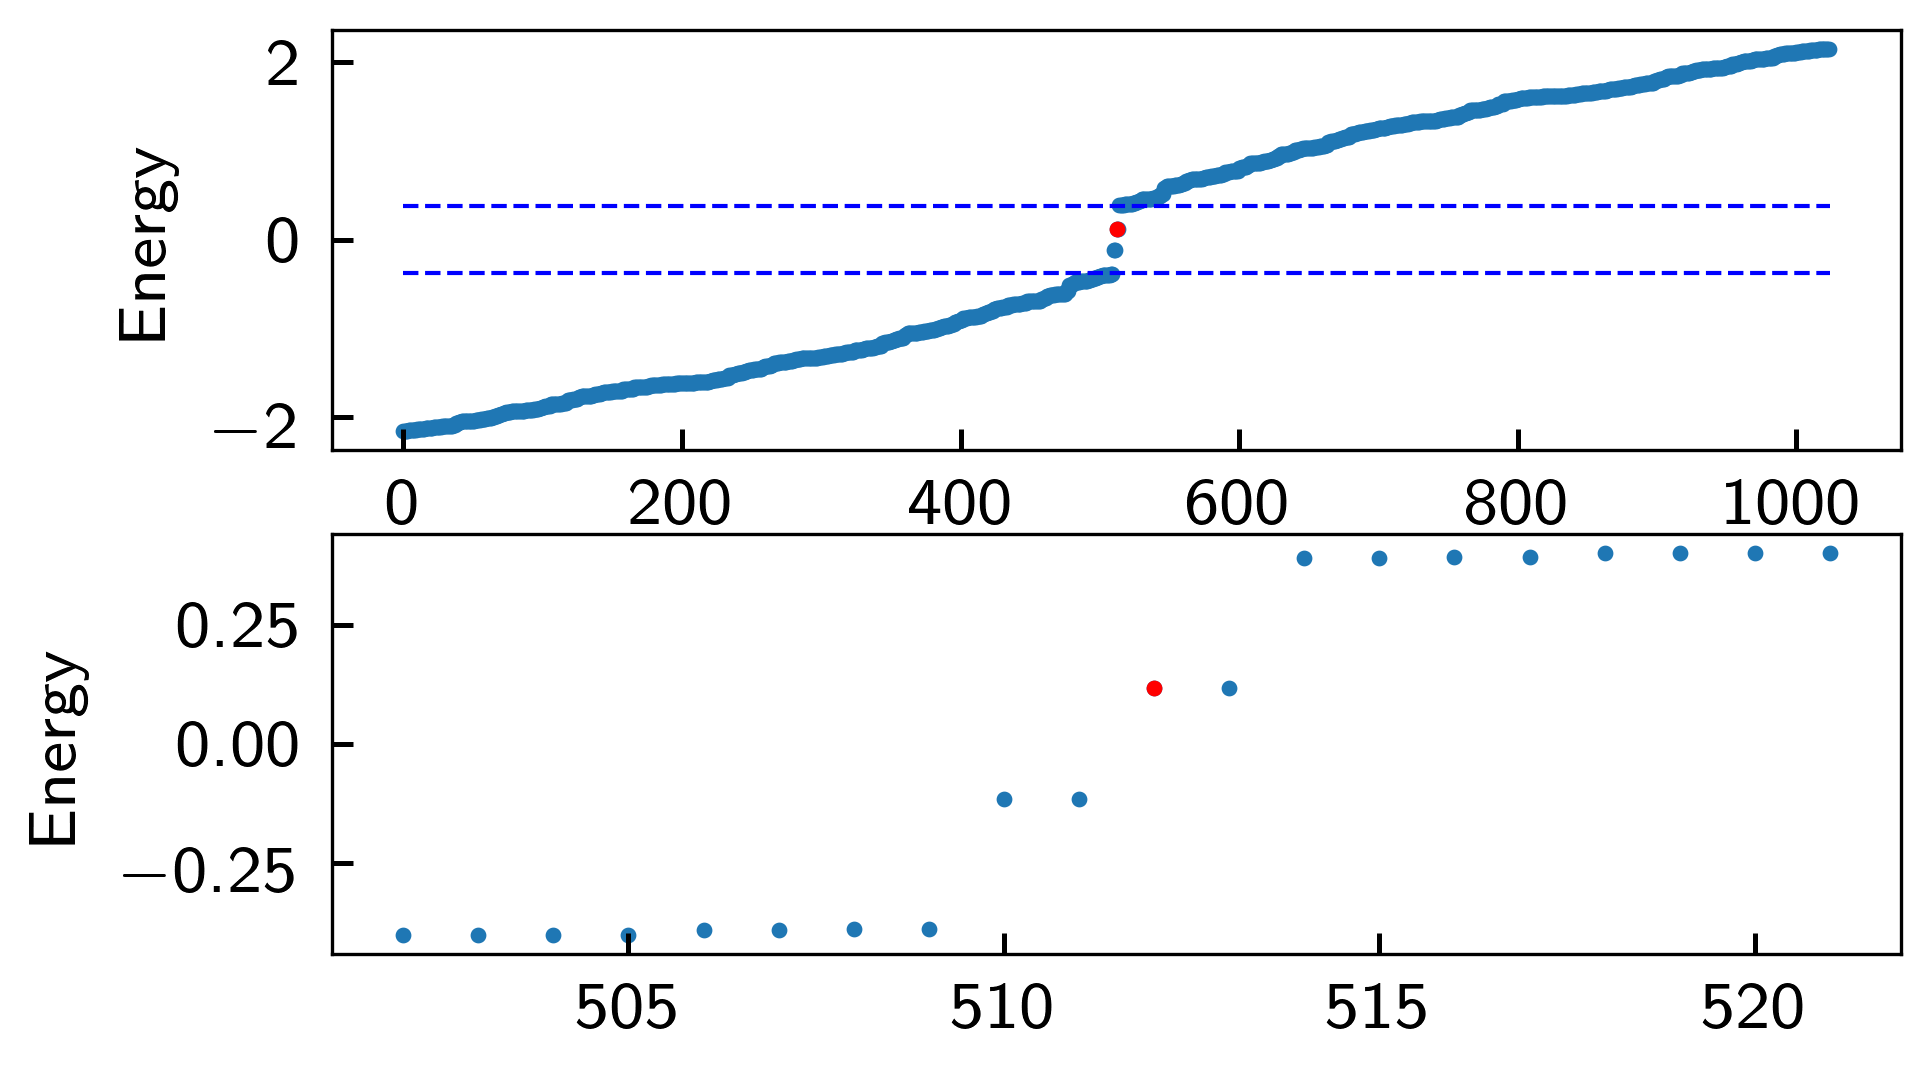

In [87]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

ax1.scatter(np.arange(len(ws)), ws, s=0.8)
ax1.scatter(idx, ws[idx], c="r", s=0.8)
ax1.set_ylabel(r"Energy")
# ax1.hlines([-Delta_init, Delta_init], 0, N, color='k', linestyles='--', linewidth=0.5)
ax1.hlines([-omega_mg, omega_mg], 0, N, color="b", linestyles="--", linewidth=0.5)


ax2.scatter(np.arange(idx - 10, idx + 10), ws[idx - 10 : idx + 10], s=0.8)
ax2.scatter(idx, ws[idx], c="r", s=0.8)
ax2.set_ylabel(r"Energy")

In [88]:
# Calculate the densities
t0s0_d = t0s0_op(vs[:, idx])
t0sz_d = t0sz_op(vs[:, idx])
tzs0_d = tzs0_op(vs[:, idx])
tzsz_d = tzsz_op(vs[:, idx])

txs0_d = txs0_op(vs[:, idx])
tys0_d = tys0_op(vs[:, idx])
txsx_d = txsx_op(vs[:, idx])
txsy_d = txsy_op(vs[:, idx])
txsz_d = txsz_op(vs[:, idx])
tysx_d = tysx_op(vs[:, idx])
tysy_d = tysy_op(vs[:, idx])
tysz_d = tysz_op(vs[:, idx])

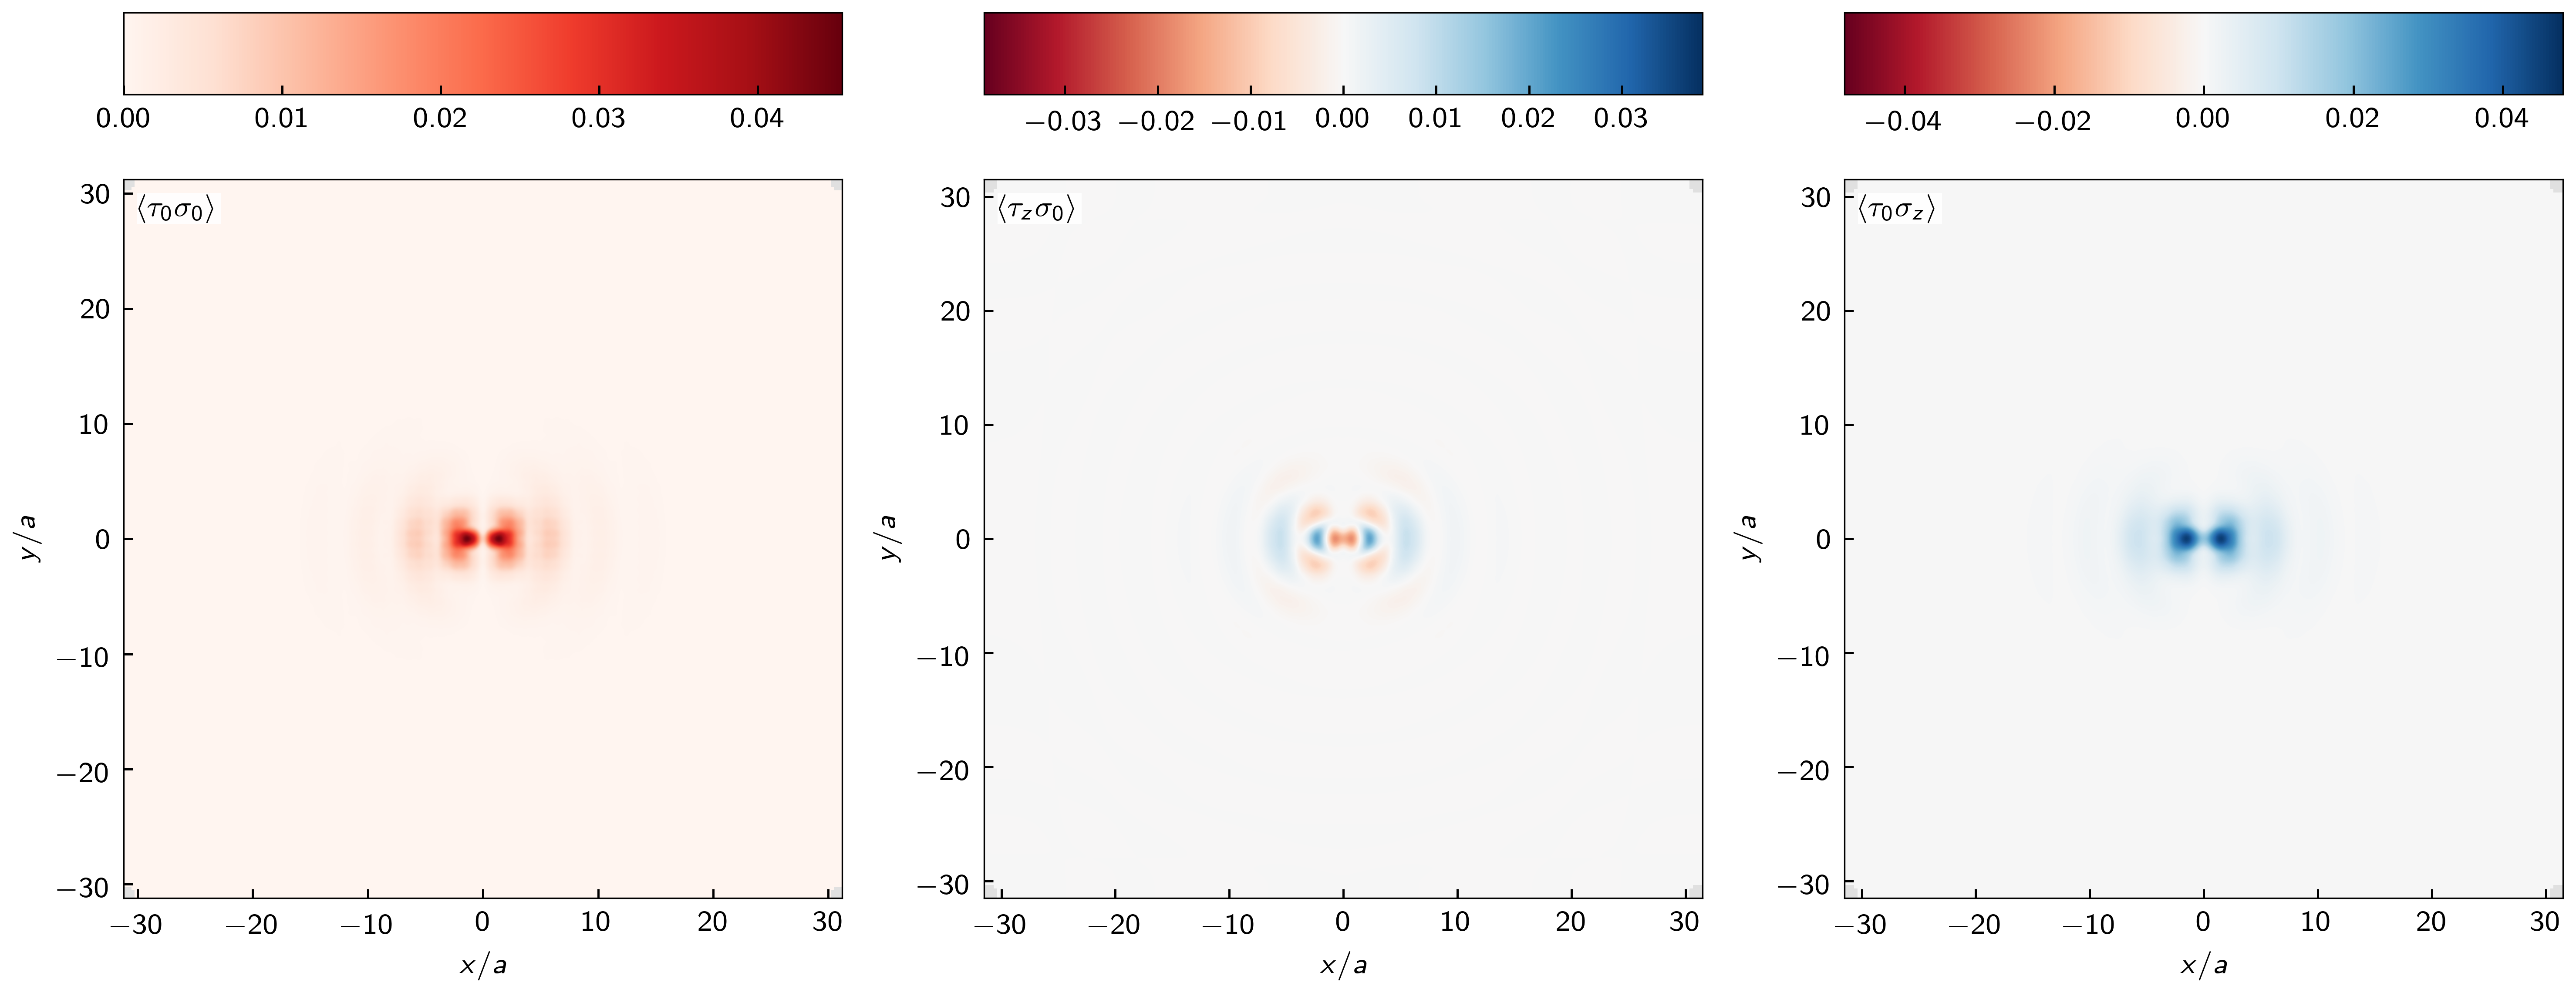

In [91]:
# Your existing code
fig = plt.figure(figsize=(10, 4))
gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.1, 1])

ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])

cax1 = plt.subplot(gs[0, 0])
cax2 = plt.subplot(gs[0, 1])
cax3 = plt.subplot(gs[0, 2])

im1 = kwant.plotter.density(
    fsyst, t0s0_d, ax=ax1, cmap="Reds", colorbar=cax1, relwidth=0.04
)
im2 = kwant.plotter.density(
    fsyst, tzs0_d, ax=ax2, cmap="RdBu", vmin=-abs(tzs0_d).max(), vmax=+abs(tzs0_d).max()
)
im3 = kwant.plotter.density(
    fsyst, t0sz_d, ax=ax3, cmap="RdBu", vmin=-abs(t0sz_d).max(), vmax=+abs(t0sz_d).max()
)

cbar1 = plt.colorbar(ax1.images[0], cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(ax2.images[0], cax=cax2, orientation="horizontal")
cbar3 = plt.colorbar(ax3.images[0], cax=cax3, orientation="horizontal")

add_tl_label(ax1, r"$\langle \tau_0 \sigma_0 \rangle$")
add_tl_label(ax2, r"$\langle \tau_z \sigma_0 \rangle$")
add_tl_label(ax3, r"$\langle \tau_0 \sigma_z \rangle$")

ax1.set_xlabel(r"$x/a$")
ax2.set_xlabel(r"$x/a$")
ax3.set_xlabel(r"$x/a$")

ax1.set_ylabel(r"$y/a$")
ax2.set_ylabel(r"$y/a$")
ax3.set_ylabel(r"$y/a$")

fig.tight_layout()

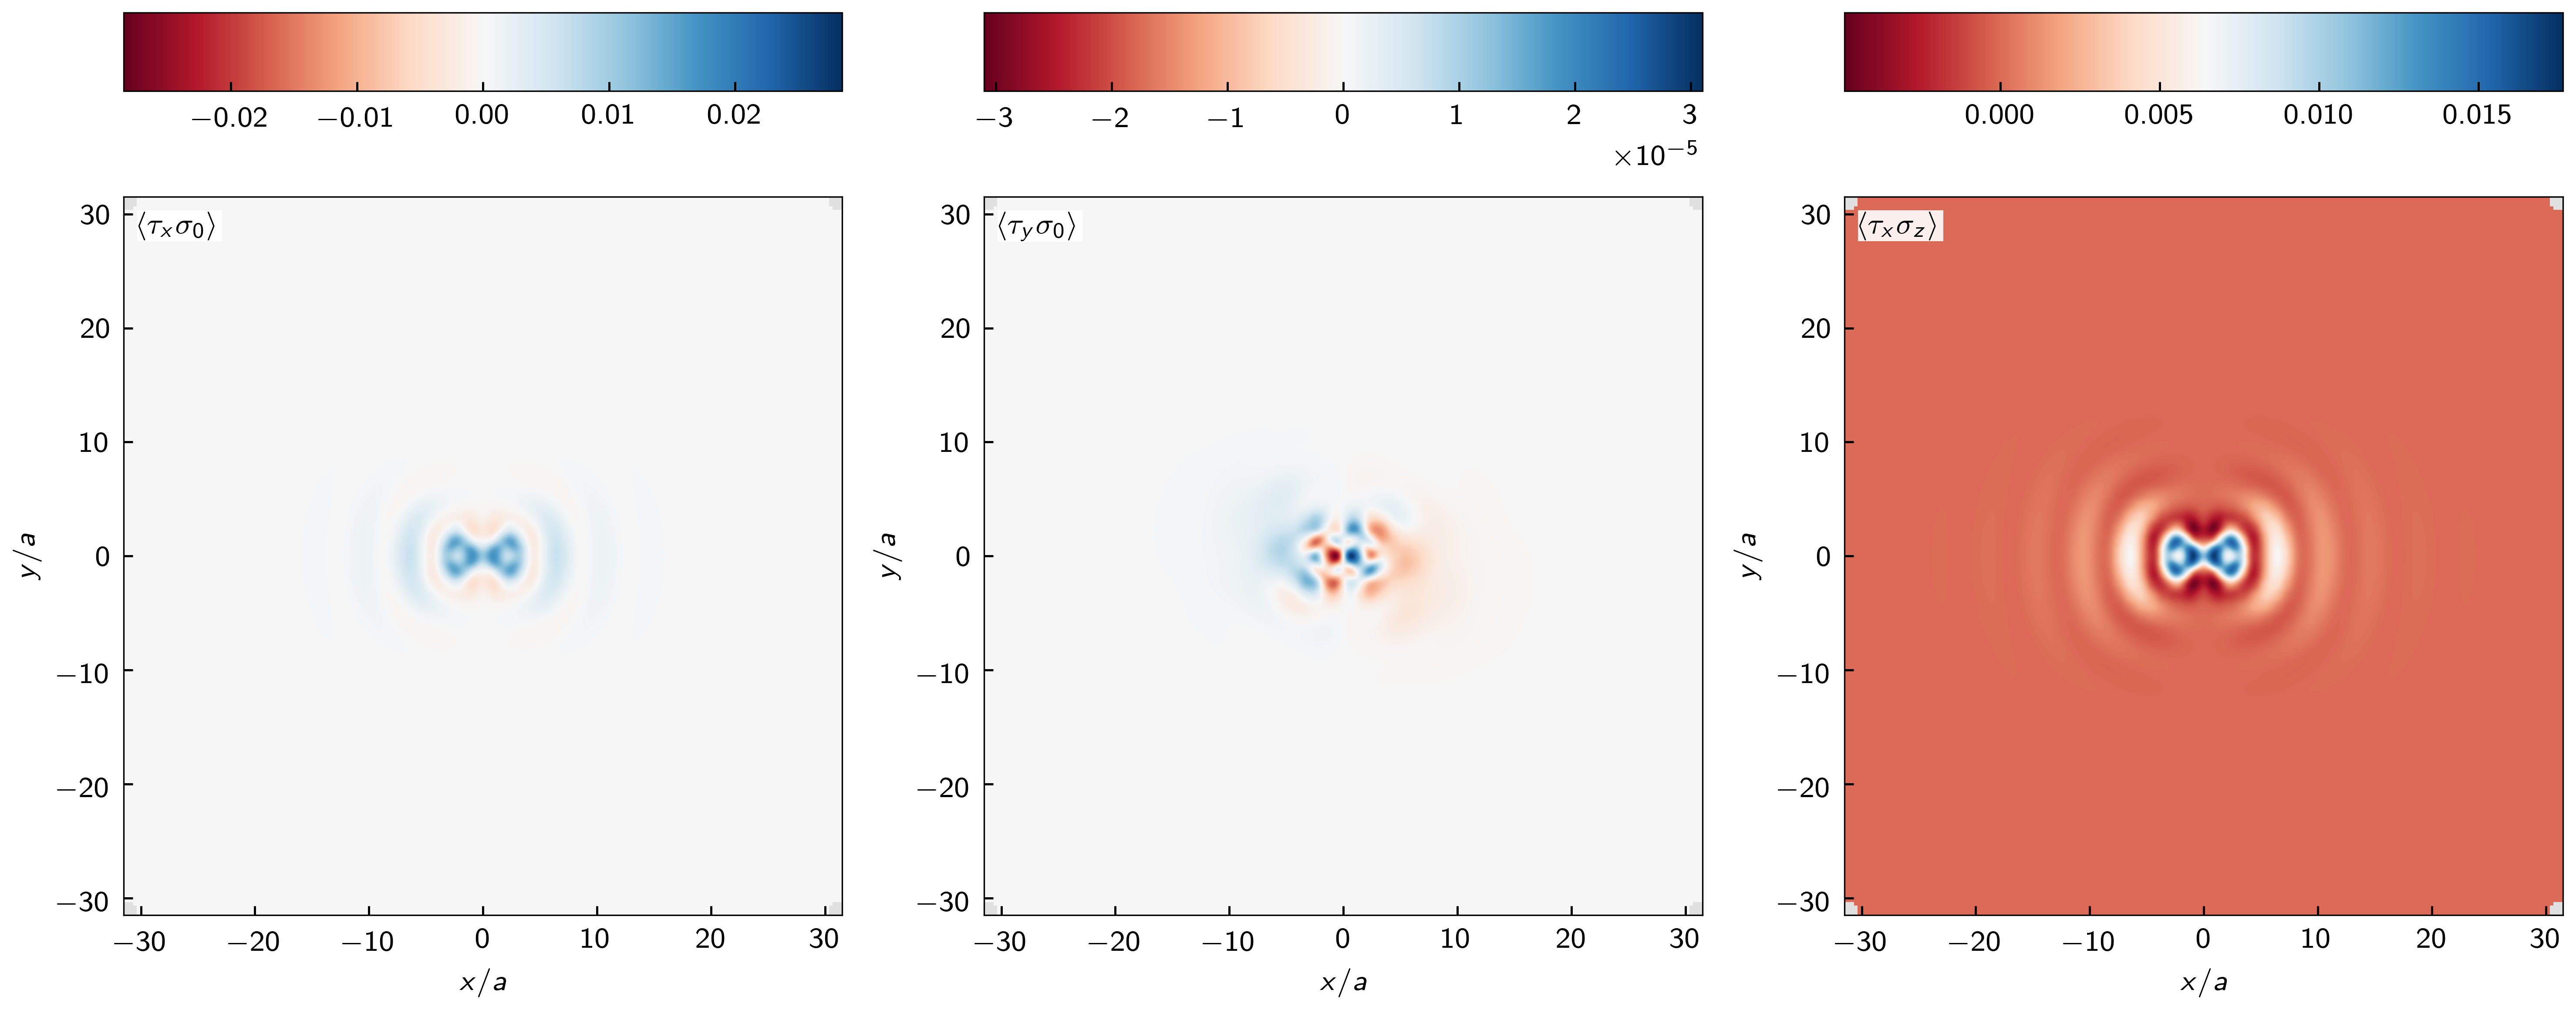

In [34]:
fig = plt.figure(figsize=(10, 4))
gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.1, 1])

ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])

cax1 = plt.subplot(gs[0, 0])
cax2 = plt.subplot(gs[0, 1])
cax3 = plt.subplot(gs[0, 2])

im1 = kwant.plotter.density(
    fsyst,
    txs0_d,
    ax=ax1,
    cmap="RdBu",
    colorbar=cax1,
    vmin=-abs(txs0_d).max(),
    vmax=abs(txs0_d).max(),
)
im2 = kwant.plotter.density(fsyst, tys0_d, ax=ax2, cmap="RdBu")
im3 = kwant.plotter.density(fsyst, txsz_d, ax=ax3, cmap="RdBu")

cbar1 = plt.colorbar(ax1.images[0], cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(ax2.images[0], cax=cax2, orientation="horizontal")
cbar3 = plt.colorbar(ax3.images[0], cax=cax3, orientation="horizontal")

# Add labels to the top-left corner of each plot

add_tl_label(ax1, r"$\langle \tau_x \sigma_0 \rangle$")
add_tl_label(ax2, r"$\langle \tau_y \sigma_0 \rangle$")
add_tl_label(ax3, r"$\langle \tau_x \sigma_z \rangle$")

ax1.set_xlabel(r"$x/a$")
ax2.set_xlabel(r"$x/a$")
ax3.set_xlabel(r"$x/a$")

ax1.set_ylabel(r"$y/a$")
ax2.set_ylabel(r"$y/a$")
ax3.set_ylabel(r"$y/a$")

fig.tight_layout()

## Composite plots

In [35]:
idx = len(ws) // 2
ws[idx - 4 : idx + 4]

array([-0.39001405, -0.39001205, -0.11697833, -0.11697633,  0.11697633,
        0.11697833,  0.39001205,  0.39001405])

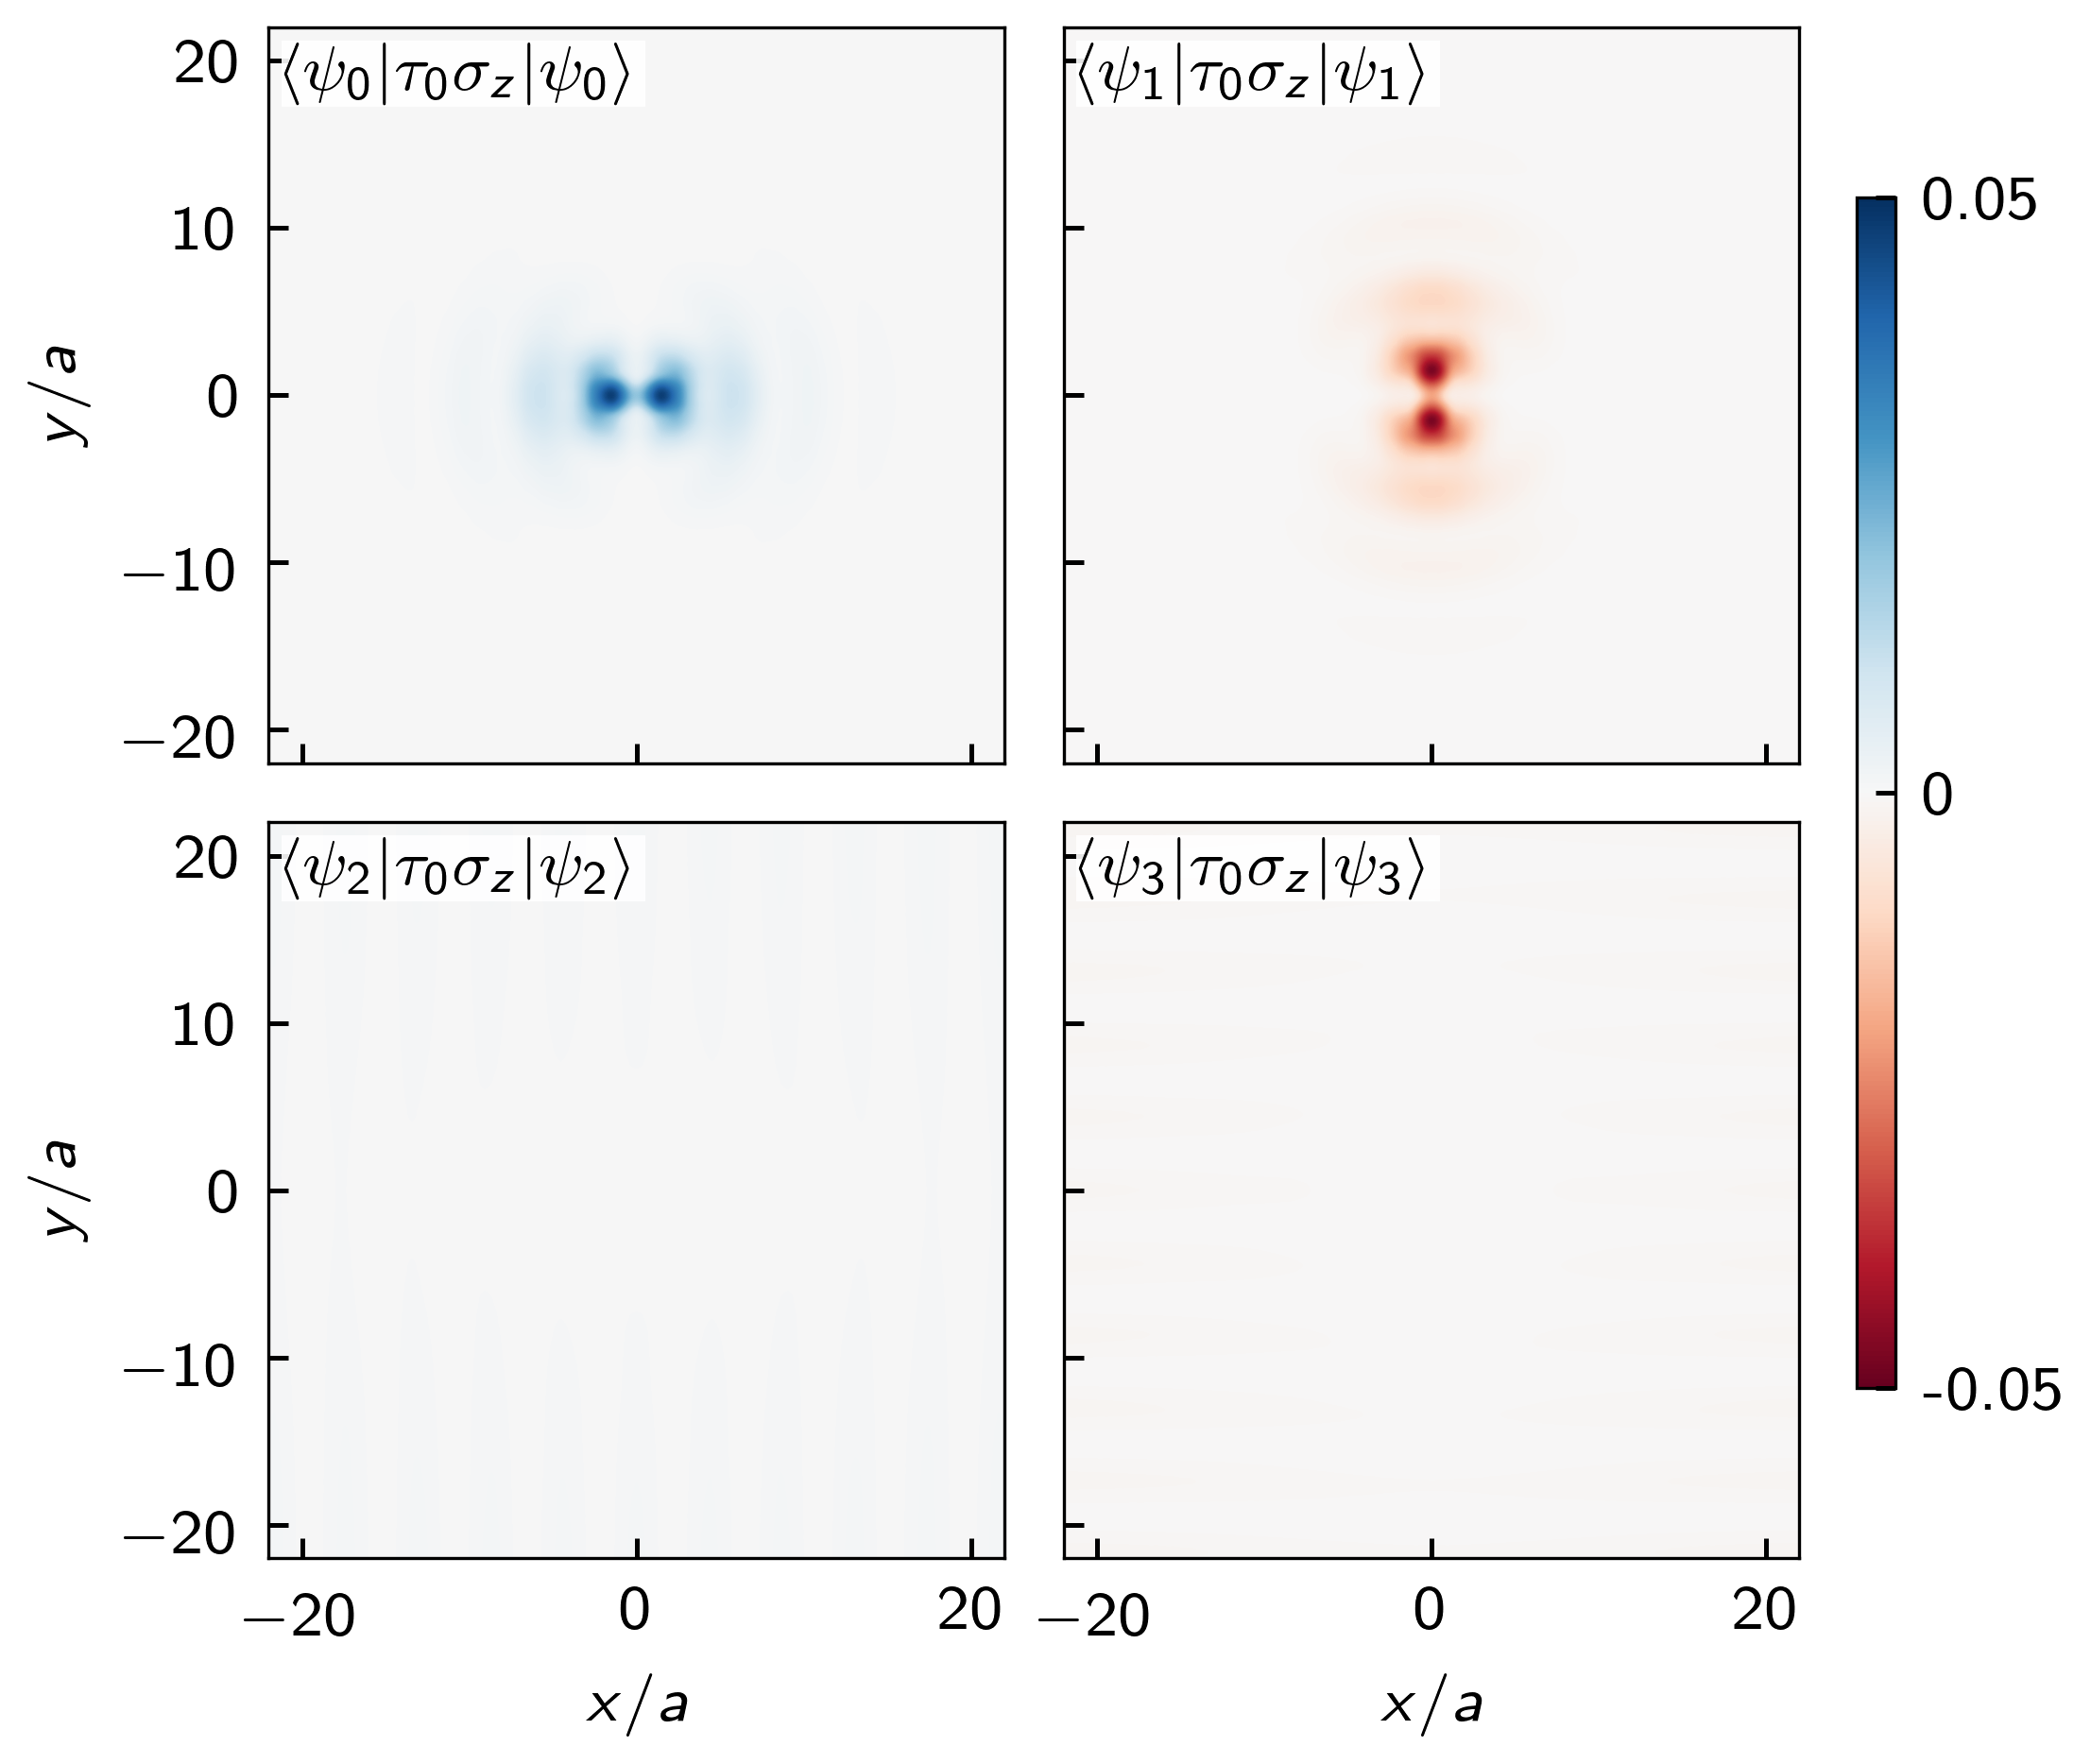

In [36]:
# Calculate index and data arrays
d_h4 = t0sz_op(vs[:, idx - 4])
d_h3 = t0sz_op(vs[:, idx - 3])
d_h2 = t0sz_op(vs[:, idx - 2])
d_h1 = t0sz_op(vs[:, idx - 1])

d_e1 = t0sz_op(vs[:, idx + 0])
d_e2 = t0sz_op(vs[:, idx + 1])
d_e3 = t0sz_op(vs[:, idx + 2])
d_e4 = t0sz_op(vs[:, idx + 3])

# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 3))
gs = fig.add_gridspec(2, 2, wspace=0.08, hspace=0.08)

# Determine color limits
vmax = np.max(np.abs([d_e1, d_e2, d_e3, d_e4]))
vmin = -vmax

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Plot densities with kwant.plotter.density
im1 = kwant.plotter.density(fsyst, d_e1, ax=ax1, cmap="RdBu", vmin=vmin, vmax=vmax)
im2 = kwant.plotter.density(fsyst, d_e2, ax=ax2, cmap="RdBu", vmin=vmin, vmax=vmax)
im3 = kwant.plotter.density(fsyst, d_e3, ax=ax3, cmap="RdBu", vmin=vmin, vmax=vmax)
im4 = kwant.plotter.density(fsyst, d_e4, ax=ax4, cmap="RdBu", vmin=vmin, vmax=vmax)

# Remove axis labels for inner plots
for ax in [ax2, ax4]:
    ax.set_yticklabels([])
for ax in [ax1, ax2]:
    ax.set_xticklabels([])

ax1.set_ylabel(r"$y/a$")
ax3.set_ylabel(r"$y/a$")
ax3.set_xlabel(r"$x/a$")
ax4.set_xlabel(r"$x/a$")

xlims = (-22, 22)
ylims = (-22, 22)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)


# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)

# Add titles for each subplot
add_tl_label(ax1, r"$\langle \psi_0 | \tau_0 \sigma_z | \psi_0 \rangle$")
add_tl_label(ax2, r"$\langle \psi_1 | \tau_0 \sigma_z | \psi_1 \rangle$")
add_tl_label(ax3, r"$\langle \psi_2 | \tau_0 \sigma_z | \psi_2 \rangle$")
add_tl_label(ax4, r"$\langle \psi_3 | \tau_0 \sigma_z | \psi_3 \rangle$")

# Create a common colorbar on the right
fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax1.images[0], cax=cbar_ax, cmap="RdBu")
cbar.set_ticks([vmin, 0, vmax])
cbar.set_ticklabels([f"{vmin:.2f}", "0", f"{vmax:.2f}"])

# Adjust layout
# gs.tight_layout(fig, rect=[0, 0, 0.85, 1])

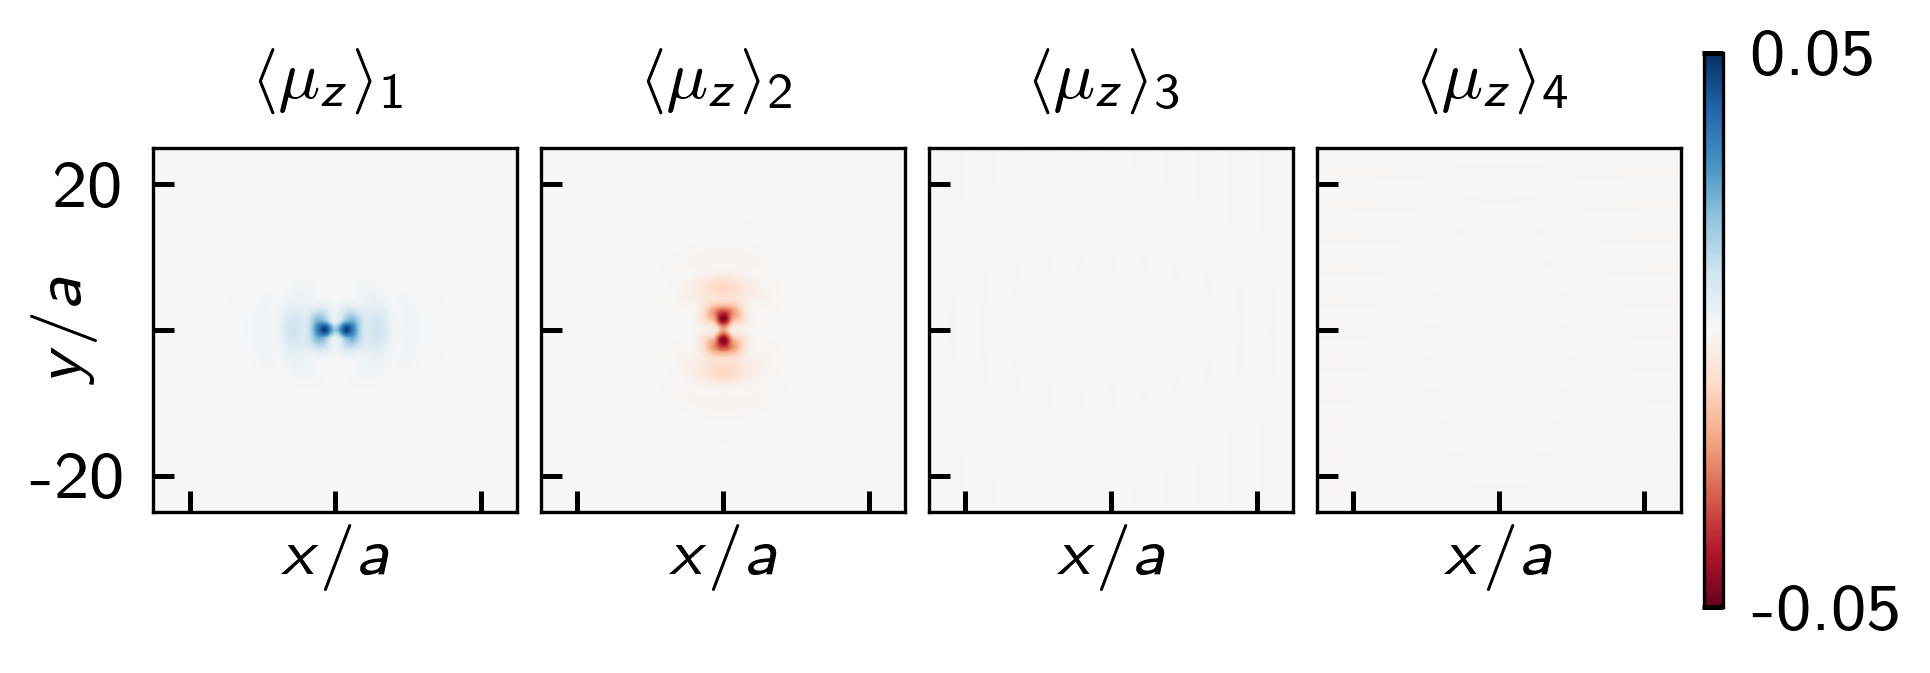

In [37]:
# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 1.2))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)

# Determine color limits
vmax = np.max(np.abs([d_e1, d_e2, d_e3, d_e4]))
vmin = -vmax

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4])

# Plot densities with kwant.plotter.density
im1 = kwant.plotter.density(fsyst, d_e1, ax=ax1, cmap="RdBu", vmin=vmin, vmax=vmax)
im2 = kwant.plotter.density(fsyst, d_e2, ax=ax2, cmap="RdBu", vmin=vmin, vmax=vmax)
im3 = kwant.plotter.density(fsyst, d_e3, ax=ax3, cmap="RdBu", vmin=vmin, vmax=vmax)
im4 = kwant.plotter.density(fsyst, d_e4, ax=ax4, cmap="RdBu", vmin=vmin, vmax=vmax)

# Set lims
xlims = (-25, 25)
ylims = (-25, 25)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-20, 0, 20], labels=["-20", "", "20"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-20, 0, 20], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-20, 0, 20], labels=[])  # labels=["-20", "", "20"])


ax1.set_ylabel(r"$y/a$", labelpad=-8)
ax1.set_xlabel(r"$x/a$", labelpad=-2)
ax2.set_xlabel(r"$x/a$", labelpad=-2)
ax3.set_xlabel(r"$x/a$", labelpad=-2)
ax4.set_xlabel(r"$x/a$", labelpad=-2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)

# Add titles for each subplot
ax1.set_title(r"$\langle \mu_z \rangle_1$")
ax2.set_title(r"$\langle \mu_z \rangle_2$")
ax3.set_title(r"$\langle \mu_z \rangle_3$")
ax4.set_title(r"$\langle \mu_z \rangle_4$")

# Create a common colorbar on the right
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap="RdBu")
cbar.set_ticks([vmin, vmax], labels=[f"{vmin:.2f}", f"{vmax:.2f}"])

# # Adjust the layout so the colorbar height matches the plot height
# fig.subplots_adjust(left=0.05, right=0.85, bottom=0.15, top=0.85)

# Adjust layout
# gs.tight_layout(fig, rect=[0, 0, 0.85, 1])

In [38]:
[
    d_h4.sum(),
    d_h3.sum(),
    d_h2.sum(),
    d_h1.sum(),
    d_e1.sum(),
    d_e2.sum(),
    d_e3.sum(),
    d_e4.sum(),
]

[0.9999999999999984,
 -0.9999999999999993,
 1.0,
 -0.999999999999998,
 0.9999999999999976,
 -1.0000000000000027,
 0.999999999999998,
 -0.9999999999999974]

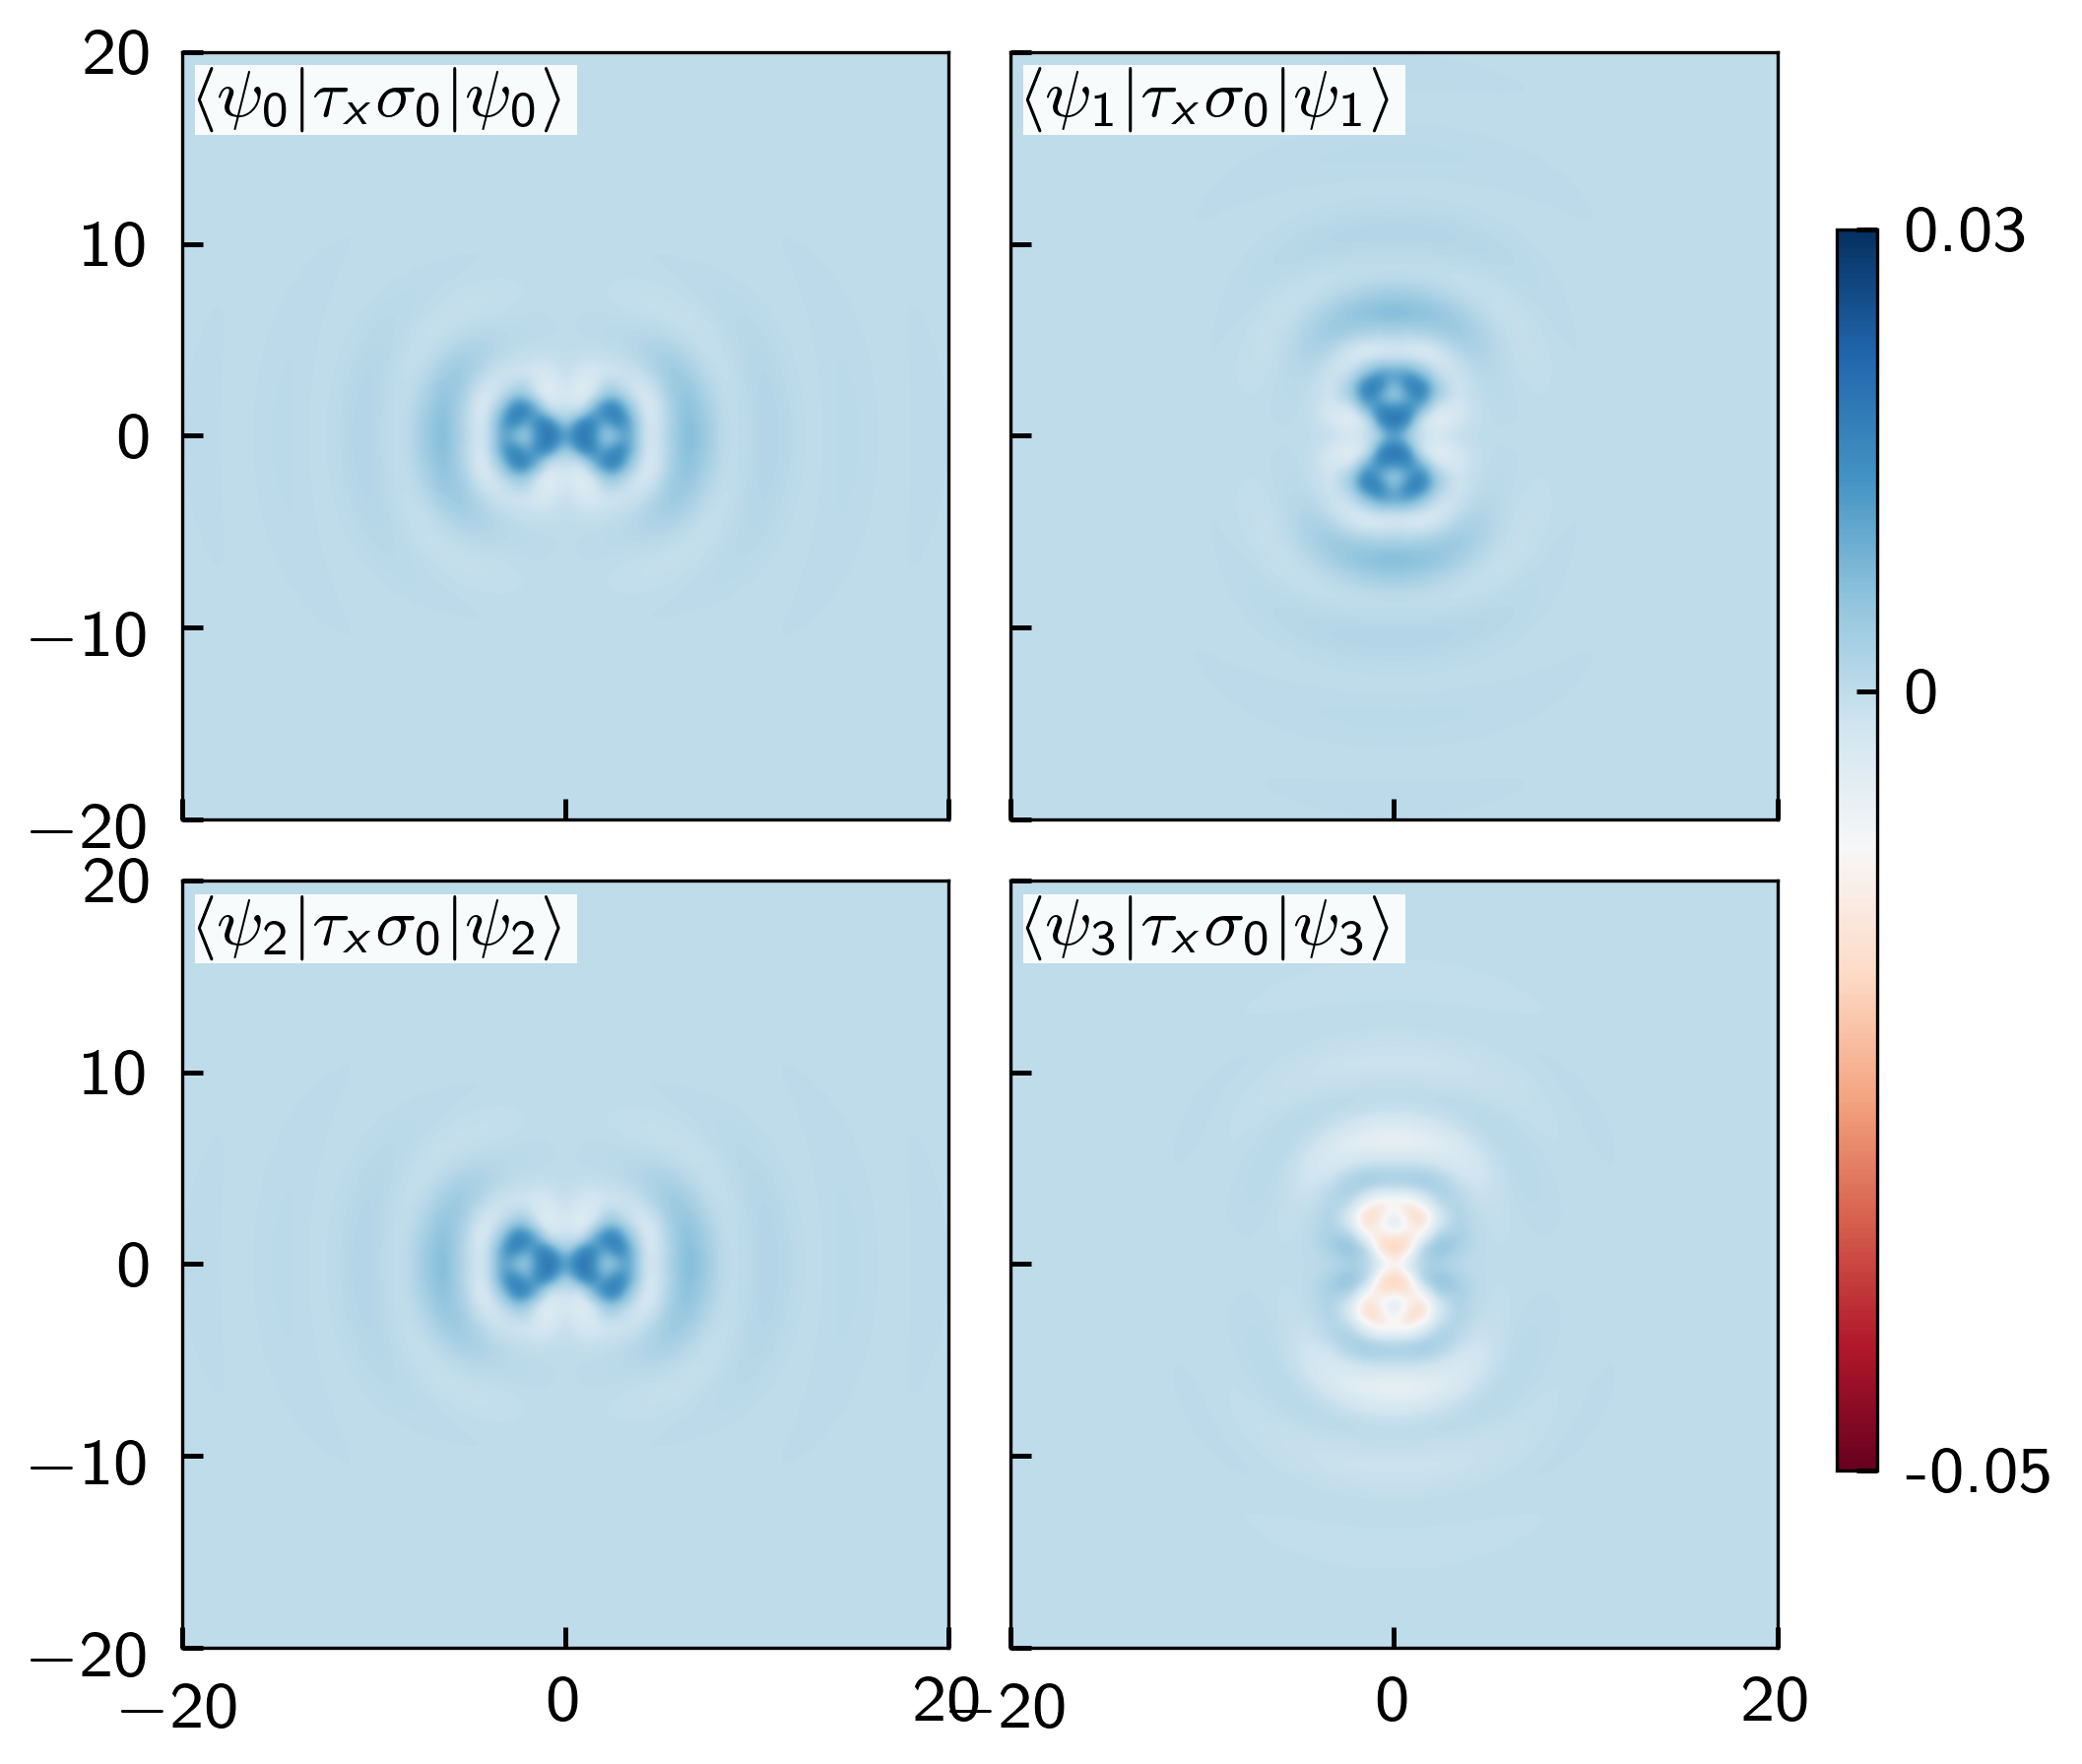

In [39]:
# Calculate index and data arrays
idx = len(ws) // 2
txs0_1 = txs0_op(vs[:, idx + 0])
txs0_2 = txs0_op(vs[:, idx + 1])
txsz_1 = txsz_op(vs[:, idx + 0])
txsz_2 = txsz_op(vs[:, idx + 1])

# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 3))
gs = fig.add_gridspec(2, 2, wspace=0.08, hspace=0.08)

# Determine color limits
vmax = +np.max(np.abs([txs0_1, txs0_2]))
vmint = -vmax

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Plot densities with kwant.plotter.density
im1 = kwant.plotter.density(fsyst, txs0_1, ax=ax1, cmap="RdBu", vmin=vmin, vmax=vmax)
im2 = kwant.plotter.density(fsyst, txs0_2, ax=ax2, cmap="RdBu", vmin=vmin, vmax=vmax)
im3 = kwant.plotter.density(fsyst, txsz_1, ax=ax3, cmap="RdBu", vmin=vmin, vmax=vmax)
im4 = kwant.plotter.density(fsyst, txsz_2, ax=ax4, cmap="RdBu", vmin=vmin, vmax=vmax)

# Remove axis labels for inner plots
for ax in [ax2, ax4]:
    ax.set_yticklabels([])
for ax in [ax1, ax2]:
    ax.set_xticklabels([])

xlims = (-20, 20)
ylims = (-20, 20)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)


# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)

# Add titles for each subplot
add_tl_label(ax1, r"$\langle \psi_0 | \tau_x \sigma_0 | \psi_0 \rangle$")
add_tl_label(ax2, r"$\langle \psi_1 | \tau_x \sigma_0 | \psi_1 \rangle$")
add_tl_label(ax3, r"$\langle \psi_2 | \tau_x \sigma_0 | \psi_2 \rangle$")
add_tl_label(ax4, r"$\langle \psi_3 | \tau_x \sigma_0 | \psi_3 \rangle$")

# Create a common colorbar on the right
fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax1.images[0], cax=cbar_ax, cmap="RdBu")
cbar.set_ticks([vmin, 0, vmax])
cbar.set_ticklabels([f"{vmin:.2f}", "0", f"{vmax:.2f}"])

# Adjust layout
# gs.tight_layout(fig, rect=[0, 0, 0.85, 1])

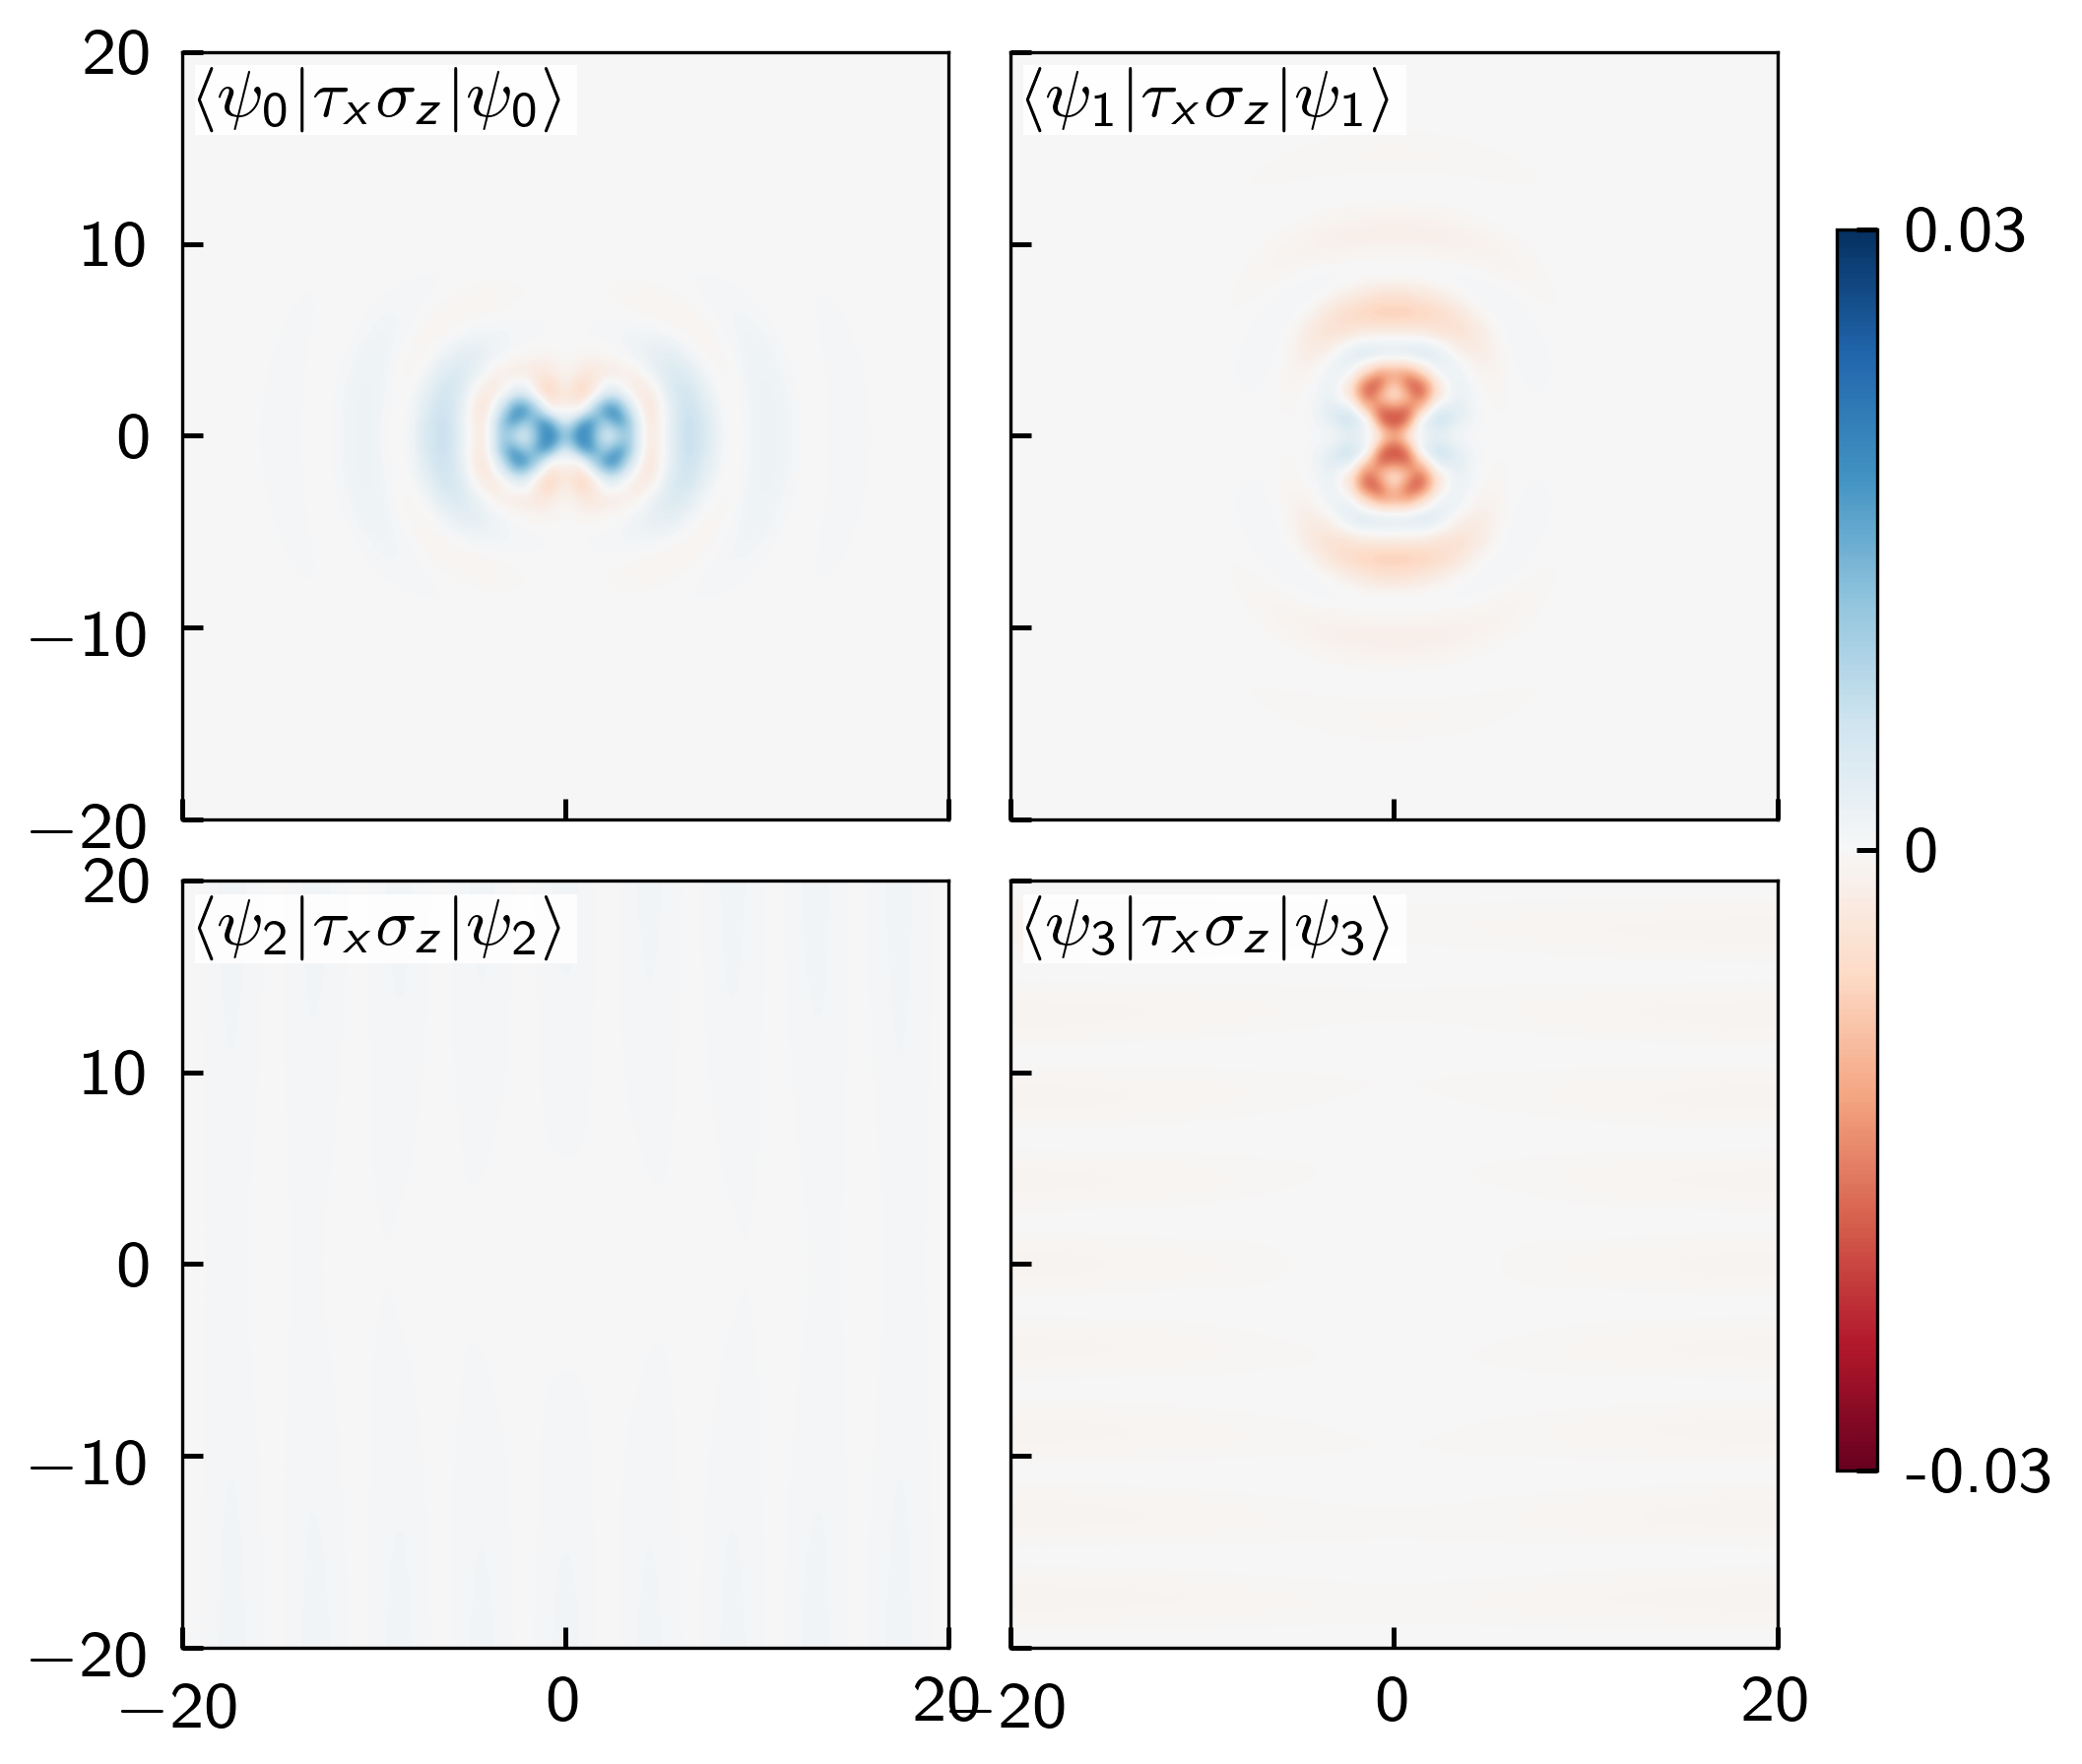

In [40]:
# Calculate index and data arrays
idx = len(ws) // 2
d_1 = txsz_op(vs[:, idx + 0])
d_2 = txsz_op(vs[:, idx + 1])
d_3 = txsz_op(vs[:, idx + 2])
d_4 = txsz_op(vs[:, idx + 3])

# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 3))
gs = fig.add_gridspec(2, 2, wspace=0.08, hspace=0.08)

# Determine color limits
vmin = -np.max(np.abs([d_1, d_2, d_3, d_4]))
vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Plot densities with kwant.plotter.density
im1 = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap="RdBu", vmin=vmin, vmax=vmax)
im2 = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap="RdBu", vmin=vmin, vmax=vmax)
im3 = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap="RdBu", vmin=vmin, vmax=vmax)
im4 = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap="RdBu", vmin=vmin, vmax=vmax)

# Remove axis labels for inner plots
for ax in [ax2, ax4]:
    ax.set_yticklabels([])
for ax in [ax1, ax2]:
    ax.set_xticklabels([])

xlims = (-20, 20)
ylims = (-20, 20)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)


# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)

# Add titles for each subplot
add_tl_label(ax1, r"$\langle \psi_0 | \tau_x \sigma_z | \psi_0 \rangle$")
add_tl_label(ax2, r"$\langle \psi_1 | \tau_x \sigma_z | \psi_1 \rangle$")
add_tl_label(ax3, r"$\langle \psi_2 | \tau_x \sigma_z | \psi_2 \rangle$")
add_tl_label(ax4, r"$\langle \psi_3 | \tau_x \sigma_z | \psi_3 \rangle$")

# Create a common colorbar on the right
fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax1.images[0], cax=cbar_ax, cmap="RdBu")
cbar.set_ticks([vmin, 0, vmax])
cbar.set_ticklabels([f"{vmin:.2f}", "0", f"{vmax:.2f}"])

# Adjust layout
# gs.tight_layout(fig, rect=[0, 0, 0.85, 1])

### Currents

In [41]:
# j_t0s0 = j_t0s0_op(vs[:, idx])
# j_tzs0 = j_tzs0_op(vs[:, idx])
# j_tzsz = j_tzsz_op(vs[:, idx])

In [42]:
# fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

# im1 = kwant.plotter.current(
#     fsyst, j_t0s0, ax=ax1, colorbar=True, min_linewidth=0.1, max_linewidth=2
# )
# im2 = kwant.plotter.current(
#     fsyst, j_tzs0, ax=ax2, colorbar=True, min_linewidth=0.1, max_linewidth=2
# )
# im3 = kwant.plotter.current(
#     fsyst, j_tzsz, ax=ax3, colorbar=True, min_linewidth=0.1, max_linewidth=2
# )

# ax1.set_xlim(-35, 35)
# ax1.set_ylim(-35, 35)

# ax2.set_xlim(-35, 35)
# ax2.set_ylim(-35, 35)

# ax3.set_xlim(-35, 35)
# ax3.set_ylim(-35, 35)